In [1]:
import os
import pandas as pd
import glob

import sys; sys.path.insert(0, "../utils/")
from data_utils import get_data_location, get_clinical_df, get_bluepoints_df, get_manual_severity_scores
from ml_pipeline import ModelEvaluation, highlight_max

DATA_PATH = get_data_location()

# Analysis

### Load yolo_detections_df if it already exists
Otherwise first run the postprocessing notebook

In [2]:
import pandas as pd
import os

if os.path.exists("yolo_detection_df.csv"):
    yolo_detection_df = pd.read_csv("yolo_detection_df.csv")
else:
    print("Yolo file does not exist")

if os.path.exists("df.csv"):
    df = pd.read_csv("df.csv")
else:
    print("df file does not exist")

In [3]:
#Load Roy data for Frame comparison
pixel_count_path = os.path.join(DATA_PATH,"cropped_videos_segmented/post_processing")

# List all files & directories
files = os.listdir(pixel_count_path)

# keep only .csv files
csvs = [x for x in files if x.endswith(".gif_pixel_counts.csv")]

# Read all csvs into one dataframe
df = pd.concat((pd.read_csv(os.path.join(pixel_count_path, f)) for f in csvs))

yolo_df_frames = yolo_detection_df[["video_name", "Frame"]].drop_duplicates().groupby("video_name").count()
roy_df_frames = df[["video_name", "Frame"]].drop_duplicates().groupby("video_name").count()
yolo_df_frames = yolo_df_frames.rename(columns={"Frame": "yolo_frames"})
roy_df_frames = roy_df_frames.rename(columns={"Frame": "roy_frames"})

frames_df = yolo_df_frames.merge(roy_df_frames, on="video_name")
frames_df["frame_diff"] = frames_df["yolo_frames"] - frames_df["roy_frames"]
frames_df["frame_diff"] = frames_df["frame_diff"].abs()
print(frames_df["frame_diff"].describe())

yolo_frames = yolo_df_frames.sum().values[0]
all_frames = roy_df_frames.sum().values[0]

print("Yolo frames: ", yolo_frames)
print("All frames: ", all_frames)
# Removed frames
print("Removed frames: ", all_frames - yolo_frames)

count    331.000000
mean      46.534743
std       33.543204
min        0.000000
25%       11.500000
50%       46.000000
75%       79.000000
max       98.000000
Name: frame_diff, dtype: float64
Yolo frames:  13348
All frames:  31243
Removed frames:  17895


#### Add manual severity labels

In [4]:
severity_manual = get_manual_severity_scores()

# Merge manual severity scores with yolo severity scores
yolo_detection_df = yolo_detection_df.merge(severity_manual[["video_name", "Severity Score"]], on="video_name", how="left")

# Rename Severity Score to manual_severity_score
yolo_detection_df.rename(columns={"Severity Score": "manual_severity_score"}, inplace=True)

# Plot number of discarded rows due to missing manual severity scores
discarded_rows = len(yolo_detection_df[yolo_detection_df["manual_severity_score"].isna()])
print("Number of discarded frames due to missing manual severity scores: {}".format(discarded_rows))

# Drop all rows where the manual severity score is not available
yolo_detection_df = yolo_detection_df.dropna(subset=["manual_severity_score"])

Number of discarded rows: 8
Number of discarded frames due to missing manual severity scores: 164


In [5]:
# Add the class names from the yolo net

# Class names: ['0: Airbronchograms', '1: Alines', '2: Blines', '3: Bpatch', '4: Consolidations', '5: Pleura', '6: Rib', '7: Shadow']
class_names = ["Airbronchograms", "Alines", "Blines", "Bpatch", "Consolidations", "Pleura", "Rib", "Shadow"]
class_name_2_idx = {class_name: idx for idx, class_name in enumerate(class_names)}
idx_2_class_name = {idx: class_name for idx, class_name in enumerate(class_names)}

# yolo_detection_df["class_name"] = yolo_detection_df["class"].apply(lambda x: class_names[x])

idx_2_class_name

{0: 'Airbronchograms',
 1: 'Alines',
 2: 'Blines',
 3: 'Bpatch',
 4: 'Consolidations',
 5: 'Pleura',
 6: 'Rib',
 7: 'Shadow'}

In [6]:
# This dataframe contains one row per object detected by the YOLONet in all frames of all bluepoint-videos of all patients
# The columns are:
# - class: the class of the object detected by the YOLONet
# - confidence: the confidence of the YOLONet in the detection
# - x: the x-coordinate of the center of the bounding box
# - y: the y-coordinate of the center of the bounding box
# - w: the width of the bounding box
# - h: the height of the bounding box
# - area: the area of the bounding box
# - video_name: the name of the video
# - Frame: the frame number
#...
# - Patient ID: the ID of the patient
# - Bluepoint: the name of the bluepoint
# - COVID19: the clinical diagnosis of the patient
# - yolo_quality_score: the quality score of the YOLONet
# - yolo_quality: the quality of the YOLONet
# - yolo_severity_score: the severity score of the YOLONet
# - class_name: the name of the class
yolo_detection_df.head()

,class,confidence,x,y,w,h,area,video_name,Frame,image_file,...,Patient ID,Bluepoint,input_file,COVID19,label_csv,yolo_quality_score,yolo_quality,yolo_severity_score,class_name,manual_severity_score
0,1,0.283368,0.230000,0.520000,0.191429,0.091429,0.017502,image_10041852062730,10,010_image_10041852062730.jpg,...,A009,R3,010_image_10041852062730.jpg,0,0 1 2 3 ...,75.0,"Good,",0.0,Alines,0.0
1,5,0.435672,0.457143,0.067143,0.274286,0.082857,0.022727,image_10041852062730,10,010_image_10041852062730.jpg,...,A009,R3,010_image_10041852062730.jpg,0,0 1 2 3 ...,75.0,"Good,",0.0,Pleura,0.0
2,5,0.269625,0.458571,0.061429,0.282857,0.082857,0.023437,image_10041852062730,17,017_image_10041852062730.jpg,...,A009,R3,017_image_10041852062730.jpg,0,0 1 2 3 ...,75.0,"Good,",0.0,Pleura,0.0
3,1,0.276546,0.271429,0.528571,0.205714,0.097143,0.019984,image_10041852062730,17,017_image_10041852062730.jpg,...,A009,R3,017_image_10041852062730.jpg,0,0 1 2 3 ...,75.0,"Good,",0.0,Alines,0.0
4,5,0.310261,0.460000,0.062857,0.285714,0.085714,0.024490,image_10041852062730,18,018_image_10041852062730.jpg,...,A009,R3,018_image_10041852062730.jpg,0,0 1 2 3 ...,75.0,"Good,",0.0,Pleura,0.0


In [7]:
# Check the distribution of the quality scores
yolo_detection_df["yolo_quality_score"].value_counts()

85.0     13462
100.0    12255
75.0     11840
55.0      9347
90.0      5616
Name: yolo_quality_score, dtype: int64

In [8]:
class_name_grp = yolo_detection_df[["video_name","Frame", "class_name"]].drop_duplicates().groupby(["video_name","Frame"])

# For all class names in class_names count the frames in which the class name is present
class_name_counts = class_name_grp["class_name"].value_counts().unstack().fillna(0)
# Sum up all counts for all class names
class_percentages_per_frame = class_name_counts.sum(axis=0) / yolo_frames * 100
# print the percentages formatted as .2f
class_percentages_per_frame.apply(lambda x: "{:.2f}%".format(x))


class_name
Airbronchograms     2.26%
Alines             48.17%
Blines             18.08%
Bpatch             20.32%
Consolidations      0.41%
Pleura             99.60%
Rib                41.33%
Shadow             55.48%
dtype: object

### Severity Score analysis

In [9]:
# Statistical test to check whether the COVID cases have on average different severity scores
from scipy import stats as st
from scipy.stats import mannwhitneyu
from scipy.stats import spearmanr


# Frame-wise severity score
frame_level = yolo_detection_df.groupby(["Frame", "video_name"]).first().reset_index().drop(columns=["class", "confidence", "x", "y", "w", "h", "area", "class_name"])

# Filter out frames with low quality
severity_filtered = frame_level[frame_level.yolo_severity_score >= 0]
x0 = severity_filtered[severity_filtered["COVID19"] == 0]["yolo_severity_score"]
x1 = severity_filtered[severity_filtered["COVID19"] == 1]["yolo_severity_score"]

# T-Test for independent samples
ttest = st.ttest_ind(a=x0, b=x1, equal_var=True)
print(f"T-Test: statistic={ttest.statistic:.4f}, p-value={ttest.pvalue:.4f}")

# Mann-Whitney U-Test
stat, p_value = mannwhitneyu(x0, x1)
print(f"Mann–Whitney U Test: statistic={stat:.4f}, p-value={p_value:.4f}")

# Print green if p-value is significant otherwise red
if p_value < 0.05:
    print("\033[92mSignificant difference\033[0m")
else:
    print("\033[91mNo significant difference\033[0m")

T-Test: statistic=-25.6312, p-value=0.0000
Mann–Whitney U Test: statistic=11464202.5000, p-value=0.0000
Significant difference


The distributions are significantly different.

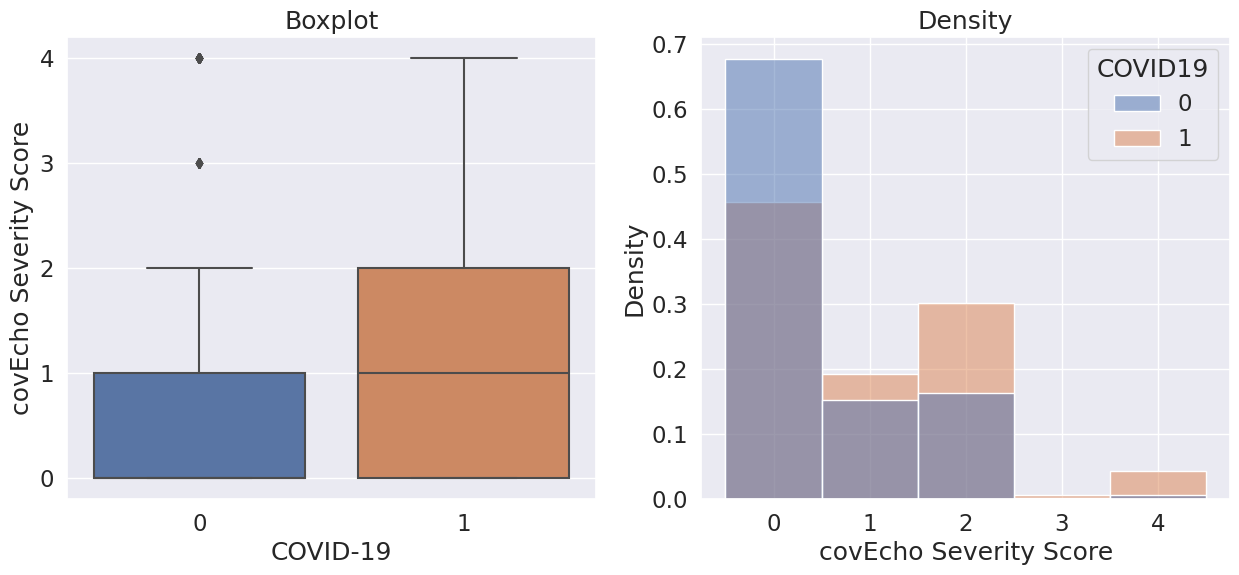

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
#set seaborn plotting aesthetics as default
sns.set(font_scale=1.5)
#define plotting region 
# fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# #Create different views of the severity score against the COVID19 diagnosis
# sns.boxplot(data=severity_filtered, x='COVID19', y='yolo_severity_score', ax=axes[0,0]).set(title='Boxplot')
# sns.histplot(data=severity_filtered, x='yolo_severity_score', hue='COVID19', bins=4, ax=axes[0,1]).set(title='Histogram')
# sns.histplot(data=severity_filtered, x='yolo_severity_score', hue='COVID19', bins=4, stat='density', common_norm=False, ax=axes[1,0]).set(title='Density')
# sns.kdeplot(x='yolo_severity_score', data=severity_filtered, hue='COVID19', common_norm=False, ax=axes[1,1]).set(title='KDE')
# plt.show()

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

#Create boxplot and density plot views of the severity score against the COVID19 diagnosis
sns.boxplot(data=severity_filtered, x='COVID19', y='yolo_severity_score', ax=axes[0]).set(title='Boxplot', xlabel='COVID-19', ylabel='covEcho Severity Score')
# Set y-axis to 0, 1, 2, 3, 4
axes[0].set_yticks([0, 1, 2, 3, 4])
sns.histplot(data=severity_filtered, x='yolo_severity_score', hue='COVID19', bins=4, stat='density', common_norm=False, ax=axes[1], discrete=True).set(title='Density', xlabel='covEcho Severity Score', ylabel='Density')

# sns.boxplot(data=severity_filtered, x='COVID19', y='yolo_severity_score', ax=0 ).set(title='Boxplot', xlabel='COVID-19', ylabel='covEcho Severity Score')
# sns.histplot(data=severity_filtered, x='yolo_severity_score', hue='COVID19', bins=4, stat='density', common_norm=False, ax=1).set(title='Density', xlabel='covEcho Severity Score', ylabel='Density')
plt.show()

In [11]:
# Correlate covid with severity score
corr = severity_filtered.yolo_severity_score.corr(severity_filtered.COVID19)
print(f"Correlation between severity score and COVID19 diagnosis: {corr:.4f}")

from scipy.stats import spearmanr

#Calculate Spearman Rank correlation and corresponding p-value
rho, p = spearmanr(severity_filtered['yolo_severity_score'], severity_filtered['COVID19'])
print(f"Spearman Rank correlation: rho={rho:.4f}, p-value={p:.4f}")


Correlation between severity score and COVID19 diagnosis: 0.2363
Spearman Rank correlation: rho=0.2347, p-value=0.0000


Correlation is not very high. From the plot there seem to be a lot of FP and FN

### Compare with severity manual labels

In [12]:
# Drop rows with missing severity scores
severity_comparison = severity_filtered[~severity_filtered["manual_severity_score"].isna()]
# Only keep rows with yolo severity scores >= 0
severity_comparison = severity_comparison[severity_comparison["yolo_severity_score"] >= 0]
# Select only the columns of interest
severity_comparison = severity_comparison[["Patient ID", "Patient ID", "video_name", "yolo_severity_score", "manual_severity_score", "COVID19"]]
# Drop duplicates
severity_comparison = severity_comparison.drop_duplicates()

severity_comparison.head()

,Patient ID,Patient ID,video_name,yolo_severity_score,manual_severity_score,COVID19
1,A009,A009,image_10179820176167,0.0,1.0,0
2,A046,A046,image_10181979512104,2.0,0.0,1
3,A015,A015,image_10200465667045,0.0,0.0,1
4,A046,A046,image_10224122725109,1.0,1.0,1
5,A046,A046,image_10264974319468,1.0,1.0,1


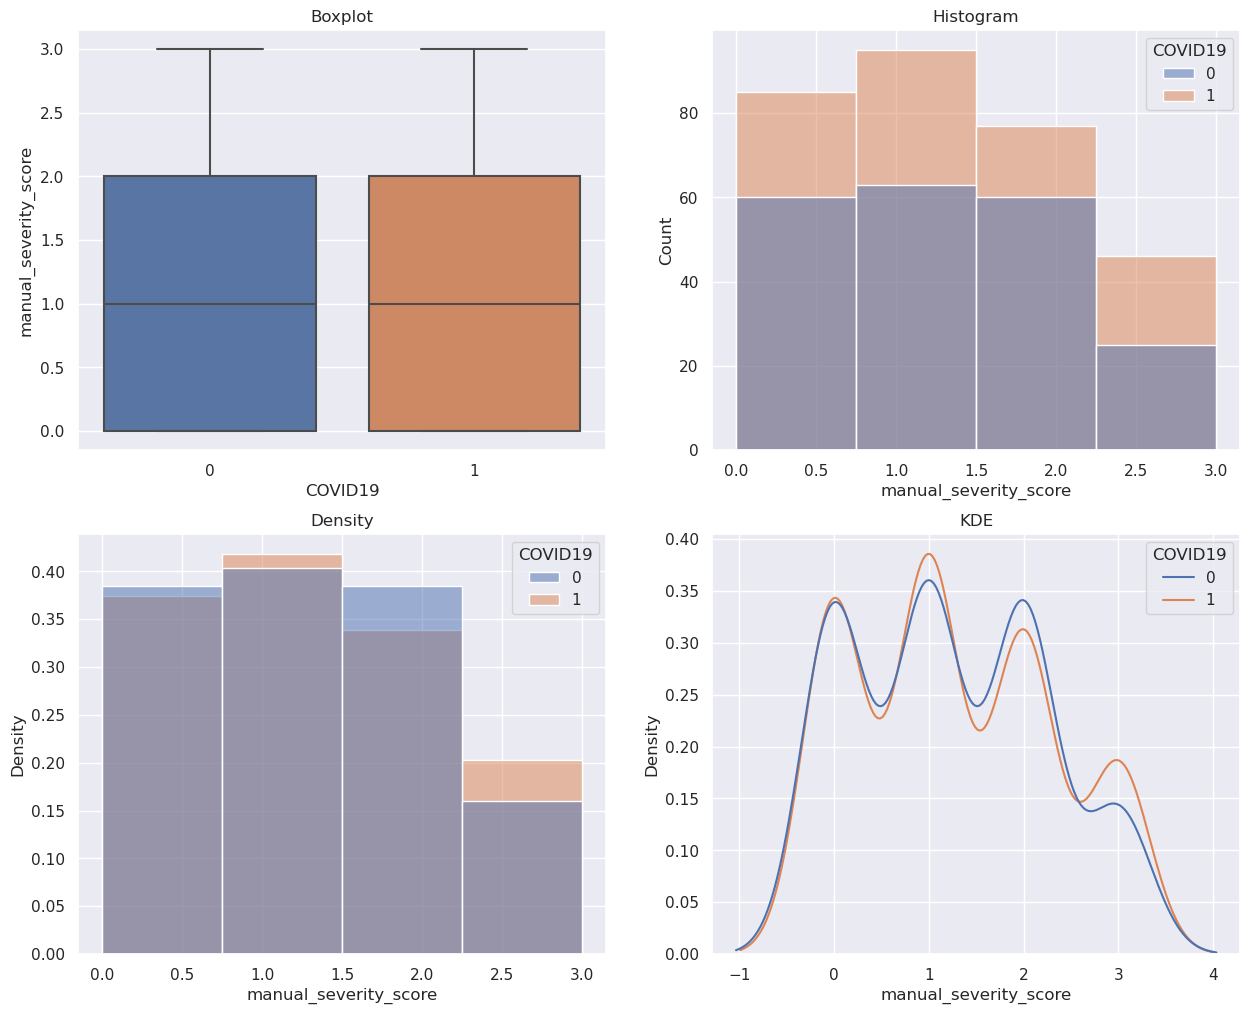

In [13]:
#set seaborn plotting aesthetics as default
sns.set()
#define plotting region 
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

#Create different views of the severity score against the COVID19 diagnosis
sns.boxplot(data=severity_comparison, x='COVID19', y='manual_severity_score', ax=axes[0,0]).set(title='Boxplot')
sns.histplot(data=severity_comparison, x='manual_severity_score', hue='COVID19', bins=4, ax=axes[0,1]).set(title='Histogram')
sns.histplot(data=severity_comparison, x='manual_severity_score', hue='COVID19', bins=4, stat='density', common_norm=False, ax=axes[1,0]).set(title='Density')
sns.kdeplot(x='manual_severity_score', data=severity_comparison, hue='COVID19', common_norm=False, ax=axes[1,1]).set(title='KDE')
plt.show()

In [14]:
# Correlate manual severity scores with yolo severity scores
severity_comparison.yolo_severity_score.corr(severity_comparison["manual_severity_score"])

0.09730909199836868

In [15]:
from scipy.stats import spearmanr

#Calculate Spearman Rank correlation and corresponding p-value
rho, p = spearmanr(severity_comparison['yolo_severity_score'], severity_comparison['manual_severity_score'])

#Print Spearman rank correlation and p-value
print(f"Spearman Rank correlation: rho={rho:.4f}, p-value={p:.4f}")


Spearman Rank correlation: rho=0.1498, p-value=0.0007


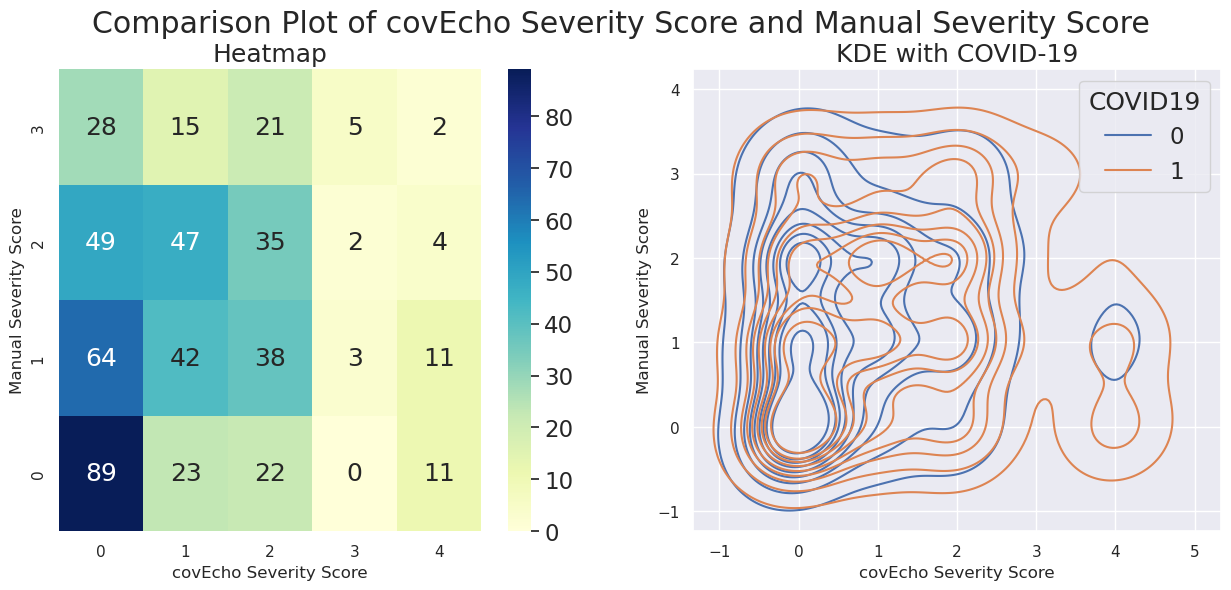

In [16]:
# Heatmap creation
pair_counts = severity_comparison[["yolo_severity_score", "manual_severity_score"]].value_counts().reset_index().rename(columns={0: "count"})
# Convert columns to int
pair_counts["yolo_severity_score"] = pair_counts["yolo_severity_score"].astype(int)
pair_counts["manual_severity_score"] = pair_counts["manual_severity_score"].astype(int)

pair_counts = pair_counts.pivot(index='manual_severity_score', columns='yolo_severity_score', values='count').fillna(0)
pair_counts = pair_counts.reindex(index=pair_counts.index[::-1])
# Convert all columns to int
for col in pair_counts.columns:
    pair_counts[col] = pair_counts[col].astype(int)


#Plot different views of the yolo severity score against the original severity score
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
sns.set(font_scale=1.5)

# Heatmap
sns.heatmap(pair_counts, annot=True, cmap="YlGnBu", fmt="d", ax=axes[0]).set(title='Heatmap')

# KDE plot
# sns.kdeplot(x='yolo_severity_score', y='manual_severity_score', data=severity_comparison, shade=True, ax=axes[1]).set(title='KDE')
# KDE plot with covid
sns.kdeplot(x='yolo_severity_score', y='manual_severity_score', data=severity_comparison, hue='COVID19', ax=axes[1]).set(title='KDE with COVID-19')
for ax in axes:
    # set y axis label
    ax.set_ylabel('Manual Severity Score')
    ax.set_xlabel('covEcho Severity Score')

plt.suptitle("Comparison Plot of covEcho Severity Score and Manual Severity Score")


plt.show()



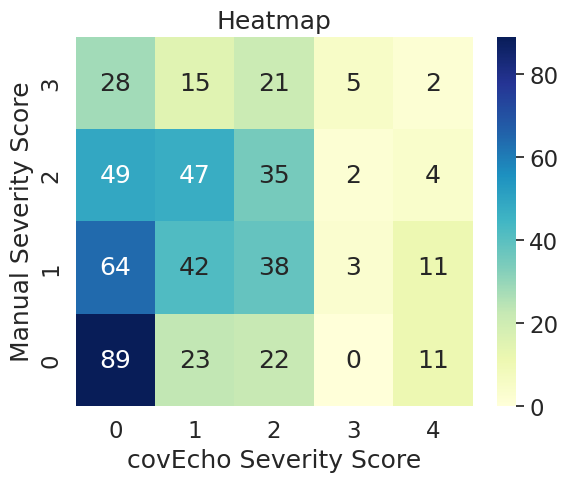

In [17]:
#Plot only heatmap
sns.heatmap(pair_counts, 
    annot=True, 
    cmap="YlGnBu", 
    fmt="d").set(title='Heatmap', xlabel='covEcho Severity Score', ylabel='Manual Severity Score')

plt.show()

#### Patient level severity analysis

In [18]:
patient_level_df = severity_filtered[["Patient ID", "Bluepoint", "video_name", "COVID19", "yolo_severity_score", "Frame", "manual_severity_score"]].sort_values(by=["Patient ID", "Bluepoint", "Frame"]).drop_duplicates()
# patient_level_df.head()

In [19]:
# Filter out severity scores < 0
patient_level_df = patient_level_df[patient_level_df["yolo_severity_score"] >= 0]


In [20]:
patient_grp = patient_level_df.groupby("Patient ID")

severity_mean = patient_grp.yolo_severity_score.mean().rename("yolo_severity_score_mean")
severtiy_sum = patient_grp.yolo_severity_score.sum().rename("yolo_severity_score_sum")
severity_max = patient_grp.yolo_severity_score.max().rename("yolo_severity_score_max")
severity_std = patient_grp.yolo_severity_score.std().rename("yolo_severity_score_std")
covid = patient_grp.COVID19.first()
accumulation_df = pd.concat([severity_mean, severtiy_sum, severity_max, severity_std, covid], axis=1)

corr_mean = accumulation_df.COVID19.corr(accumulation_df.yolo_severity_score_mean)
corr_sum = accumulation_df.COVID19.corr(accumulation_df.yolo_severity_score_sum)
corr_max = accumulation_df.COVID19.corr(accumulation_df.yolo_severity_score_max)
corr_std = accumulation_df.COVID19.corr(accumulation_df.yolo_severity_score_std)

# Calculate Spearman Rank correlation and corresponding p-value
rho_mean, p_mean = spearmanr(accumulation_df['yolo_severity_score_mean'], accumulation_df['COVID19'])
rho_sum, p_sum = spearmanr(accumulation_df['yolo_severity_score_sum'], accumulation_df['COVID19'])
rho_max, p_max = spearmanr(accumulation_df['yolo_severity_score_max'], accumulation_df['COVID19'])
rho_std, p_std = spearmanr(accumulation_df['yolo_severity_score_std'], accumulation_df['COVID19'])

# Put all into a df
corr_df = pd.DataFrame({"Correlation": [corr, corr_mean, corr_sum, corr_max, corr_std],
                        "Spearman Rank correlation": [rho, rho_mean, rho_sum, rho_max, rho_std],
                        # "p-value": [p, p_mean, p_sum, p_max, p_std]
                        },
                          index=["Severity", "Severity_mean", "Severity_sum", "Severity_max", "Severity_std"])

corr_df.style.apply(highlight_max).format("{:.2f}")


,Correlation,Spearman Rank correlation
Severity,0.24,0.15
Severity_mean,0.44,0.45
Severity_sum,0.33,0.40
Severity_max,0.35,0.34
Severity_std,0.40,0.39


Correlations of the severtiy score with covid are significantly higher on patient level

Do the same for the manual severity scores

In [21]:
# Drop patients with no manual severity score
patient_level_df_manual = patient_level_df[patient_level_df["manual_severity_score"].notna()]
# Drop frames column and drop duplicates
patient_level_df_manual = patient_level_df_manual[["Patient ID", "Bluepoint", "video_name", "COVID19", "manual_severity_score"]].sort_values(by=["Patient ID", "Bluepoint"]).drop_duplicates()
patient_level_df_manual.reset_index(drop=True, inplace=True)
patient_level_df_manual.head()

,Patient ID,Bluepoint,video_name,COVID19,manual_severity_score
0,A001,L1,image_147763479101025,0,3.0
1,A001,L2,image_147814256633037,0,3.0
2,A001,L3,image_147857626821302,0,2.0
3,A001,R1,image_147549867609700,0,1.0
4,A001,R2,image_147606973438168,0,2.0


In [22]:

patient_grp_manual = patient_level_df_manual.groupby("Patient ID")

severity_mean = patient_grp_manual.manual_severity_score.mean().rename("manual_severity_score_mean")
severtiy_sum = patient_grp_manual.manual_severity_score.sum().rename("manual_severity_score_sum")
severity_max = patient_grp_manual.manual_severity_score.max().rename("manual_severity_score_max")
severity_std = patient_grp_manual.manual_severity_score.std().rename("manual_severity_score_std")
covid = patient_grp_manual.COVID19.first()
accumulation_df_manual = pd.concat([severity_mean, severtiy_sum, severity_max, severity_std, covid], axis=1)

corr = patient_level_df_manual.manual_severity_score.corr(patient_level_df_manual.COVID19)
corr_mean = accumulation_df_manual.COVID19.corr(accumulation_df_manual.manual_severity_score_mean)
corr_sum = accumulation_df_manual.COVID19.corr(accumulation_df_manual.manual_severity_score_sum)
corr_max = accumulation_df_manual.COVID19.corr(accumulation_df_manual.manual_severity_score_max)
corr_std = accumulation_df_manual.COVID19.corr(accumulation_df_manual.manual_severity_score_std)

# Calculate Spearman Rank correlation and corresponding p-value
rho, p = spearmanr(patient_level_df_manual['manual_severity_score'], patient_level_df_manual['COVID19'])
rho_mean, p_mean = spearmanr(accumulation_df_manual['manual_severity_score_mean'], accumulation_df_manual['COVID19'])
rho_sum, p_sum = spearmanr(accumulation_df_manual['manual_severity_score_sum'], accumulation_df_manual['COVID19'])
rho_max, p_max = spearmanr(accumulation_df_manual['manual_severity_score_max'], accumulation_df_manual['COVID19'])
rho_std, p_std = spearmanr(accumulation_df_manual['manual_severity_score_std'], accumulation_df_manual['COVID19'])

# Put all into a df
corr_df = pd.DataFrame({"Correlation": [corr, corr_mean, corr_sum, corr_max, corr_std],
                        "Spearman Rank correlation": [rho, rho_mean, rho_sum, rho_max, rho_std],
                        # "p-value": [p, p_mean, p_sum, p_max, p_std]
                        },
                          index=["Severity", "Severity_mean", "Severity_sum", "Severity_max", "Severity_std"])

corr_df.style.apply(highlight_max).format("{:.2f}")


,Correlation,Spearman Rank correlation
Severity,-0.00,-0.01
Severity_mean,0.01,-0.01
Severity_sum,0.03,0.01
Severity_max,-0.08,-0.06
Severity_std,-0.03,nan


### Add n_largest mean as aggregation strategy. 
That the max performs worse than the mean can be seen as supporting the hypothesis that looking at a single predicted frame is not very informative both since:
1. the models performance is noisy and makes many missclassifications.
2. The videos have many uninformative frames

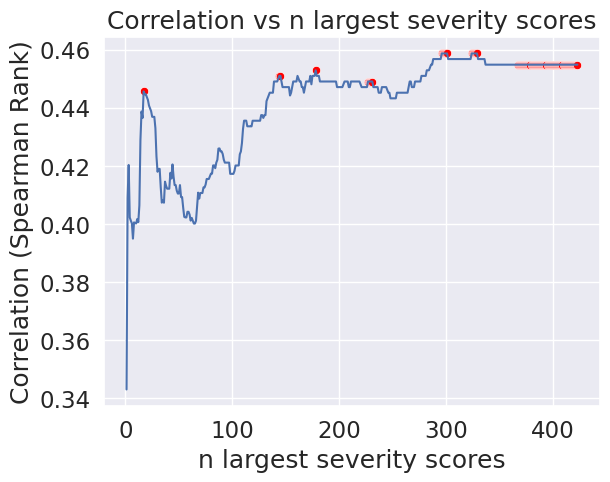

In [23]:
# Get min length of the videos
min_length = patient_grp.count().video_name.min()
max_length = patient_grp.count().video_name.max()

n_largest = []
covid = patient_grp.COVID19.first()
for i in range(1, max_length):
    mean_largest = patient_grp.yolo_severity_score.nlargest(i).groupby("Patient ID").mean()
    mean_largest = pd.concat([mean_largest, covid], axis=1)
    # n_largest.append(mean_largest.COVID19.corr(mean_largest.yolo_severity_score))
    # Append spearman rank correlation
    n_largest.append(spearmanr(mean_largest['yolo_severity_score'], mean_largest['COVID19'])[0])

n_largest = pd.DataFrame(n_largest, index=range(1, max_length), columns=["correlation"])

# Find maxima of the n_largest correlations
from scipy.signal import argrelextrema
import numpy as np
n=30
n_largest['max'] = n_largest.iloc[argrelextrema(n_largest.correlation.values, np.greater_equal,
                    order=n)[0]]['correlation']

# Plot nlargest correlation with maxima
sns.lineplot(data=n_largest, x=n_largest.index, y="correlation").set(title="Correlation vs n largest severity scores", xlabel="n largest severity scores", ylabel="Correlation (Spearman Rank)")
sns.scatterplot(data=n_largest, x=n_largest.index, y="max", color="red")
plt.show()

In [24]:
# Select only the maxima
n_largest = n_largest.dropna().reset_index().rename(columns={"index": "n_largest"}).drop(columns=["max"])
# Add the maxima to the aggregation strategies
for idx, row in n_largest.iterrows():
    n = row["n_largest"].astype(int)
    severity_nlargest_mean = patient_grp.yolo_severity_score.nlargest(n).groupby("Patient ID").mean().rename(f"yolo_severity_score_mean_largest_{n}")
    accumulation_df = pd.concat([accumulation_df, severity_nlargest_mean], axis=1)

n_largest

,n_largest,correlation
0,17,0.445614
1,144,0.450962
2,145,0.450962
3,178,0.452893
4,227,0.449031
...,...,...
73,419,0.454825
74,420,0.454825
75,421,0.454825
76,422,0.454825


### Evaluate predictive performance of severity score

In [25]:
import statistics as logit_stats
from importlib import reload
reload(logit_stats)

# Evaluate the logits of the YOLONet
gt = severity_filtered["COVID19"].values
predictions = (severity_filtered["yolo_severity_score"] >= 1).astype(int).values

eval = logit_stats.evaluate_logits(gt, predictions, CLASSES=["No COVID", "COVID"])
eval = pd.concat([eval], keys=["None"], names=['Accumulation'])
eval

precision    recall  f1-score       mcc  specificity  \
Accumulation                                                                  
None         No COVID   0.537272  0.676157  0.598767  0.219289     0.543513   
             COVID      0.681635  0.543513  0.604788  0.219289     0.676157   

                       accuracy  balanced  
Accumulation                               
None         No COVID    0.6018  0.609835  
             COVID       0.6018  0.609835

The values without patient level accumulation don't look very promising

Next try to accumulate the severity scores by different means and check the patient-level performance.

To do so we calculate get the optimal cut-off value for all aggregation strategies and evaluate the results.

In [26]:
# Trying to find optimal threshold values for all accumulation scores
import numpy as np
from sklearn.metrics import roc_curve, auc

# Taken from https://stackoverflow.com/questions/28719067/roc-curve-and-cut-off-point-python
def Find_Optimal_Cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------     
    list type, with optimal cutoff value
        
    """
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 


In [27]:
from sklearn.model_selection import train_test_split
eval_acc = eval
accumulation_columns = list(accumulation_df.columns[accumulation_df.columns.str.contains("yolo_severity_score")])
# Remove all columns containing numbers between 367 and 424
exclude_numbers = [str(i) for i in range(367, 424)]
accumulation_columns = [col for col in accumulation_columns if not any(num in col for num in exclude_numbers)]
gt = accumulation_df["COVID19"]
for acc in accumulation_columns:
    X = accumulation_df[acc]
    y = gt
    # Split into train and test to determine optimal cutoff on train set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    # Find optimal probability threshold
    threshold = Find_Optimal_Cutoff(y_train, X_train)[0]
    print(f"Threshold for {acc}: {threshold}")
    # Find prediction to the dataframe applying threshold
    predictions = X_test.map(lambda x: 1 if x > threshold else 0)
    temp = logit_stats.evaluate_logits(y_test, predictions, CLASSES=["No COVID", "COVID"])
    temp = pd.concat([temp], keys=[acc], names=['Accumulation'])
    eval_acc = pd.concat([eval_acc, temp])

eval_acc.style.apply(highlight_max)

Threshold for yolo_severity_score_mean: 0.5664739884393064
Threshold for yolo_severity_score_sum: 87.0
Threshold for yolo_severity_score_max: 3.0
Threshold for yolo_severity_score_std: 0.6136160403262757
Threshold for yolo_severity_score_mean_largest_17: 2.0
Threshold for yolo_severity_score_mean_largest_144: 0.7777777777777778
Threshold for yolo_severity_score_mean_largest_145: 0.7724137931034483
Threshold for yolo_severity_score_mean_largest_178: 0.6292134831460674
Threshold for yolo_severity_score_mean_largest_227: 0.5664739884393064
Threshold for yolo_severity_score_mean_largest_228: 0.5664739884393064
Threshold for yolo_severity_score_mean_largest_229: 0.5664739884393064
Threshold for yolo_severity_score_mean_largest_230: 0.5664739884393064
Threshold for yolo_severity_score_mean_largest_231: 0.5664739884393064
Threshold for yolo_severity_score_mean_largest_296: 0.5664739884393064
Threshold for yolo_severity_score_mean_largest_297: 0.5664739884393064
Threshold for yolo_severity_sco

In [28]:
# To latex formating .2f
print(eval_acc[["accuracy", "recall", "specificity", "f1-score"]].to_latex(float_format="%.2f"))

\begin{tabular}{llrrrr}
\toprule
                                     &       &  accuracy &  recall &  specificity &  f1-score \\
Accumulation & {} &           &         &              &           \\
\midrule
None & No COVID &      0.60 &    0.68 &         0.54 &      0.60 \\
                                     & COVID &      0.60 &    0.54 &         0.68 &      0.60 \\
yolo\_severity\_score\_mean & No COVID &      0.55 &    0.50 &         0.60 &      0.53 \\
                                     & COVID &      0.55 &    0.60 &         0.50 &      0.57 \\
yolo\_severity\_score\_sum & No COVID &      0.55 &    0.60 &         0.50 &      0.57 \\
                                     & COVID &      0.55 &    0.50 &         0.60 &      0.53 \\
yolo\_severity\_score\_max & No COVID &      0.50 &    0.70 &         0.30 &      0.58 \\
                                     & COVID &      0.50 &    0.30 &         0.70 &      0.37 \\
yolo\_severity\_score\_std & No COVID &      0.50 &    0.50 &   

This improves the results significantly. Its interesting to note that the std seems to be the most predictive variable of the simple aggregation schemas where as the max performs worst of all the accumulation strategies. This suggests that its (at least on our data without retraining the network) perhaps not the best strategy to assume that the "worst" frame suggests the state of the patient but that taking the mean or the sum is better. 
The best aggregation strategy over all is, however, to take the mean of the frames with the n largest severtiy scores. This supports the hypothesis that both looking at only one individual, most severe frame, as well as taking a vote of all the frames with equal rights is not the best method to go about determining a final diagnosis for a patient but that instead the vote of a subset of informative frames is the most promising.

### Evaluate predictive performance of manual severity labels

In [29]:
# Evaluate the logits of the YOLONet
gt = severity_filtered["COVID19"].values
predictions = (severity_filtered["manual_severity_score"] >= 1).astype(int).values

eval_manual = logit_stats.evaluate_logits(gt, predictions, CLASSES=["No COVID", "COVID"])
eval_manual

,precision,recall,f1-score,mcc,specificity,accuracy,balanced
No COVID,0.425683,0.332036,0.373072,-0.019994,0.648844,0.509631,0.49044
COVID,0.553410,0.648844,0.597339,-0.019994,0.332036,0.509631,0.49044


The predictive performance of the manual severity scores are at chance level.

## Bluepoint level severity analysis

In [30]:
severity_filtered.yolo_severity_score.corr(severity_filtered.COVID19)

0.23630527157897951

In [31]:
bluepoints = severity_filtered.Bluepoint.unique()
bluepoints = bluepoints[bluepoints != "None"]
bluepoints.sort()
bluepoints

array(['L1', 'L2', 'L3', 'R1', 'R2', 'R3'], dtype=object)

Bluepoint L1 has 2463 frames
Bluepoint L2 has 1825 frames
Bluepoint L3 has 1542 frames
Bluepoint R1 has 2409 frames
Bluepoint R2 has 1542 frames
Bluepoint R3 has 1328 frames


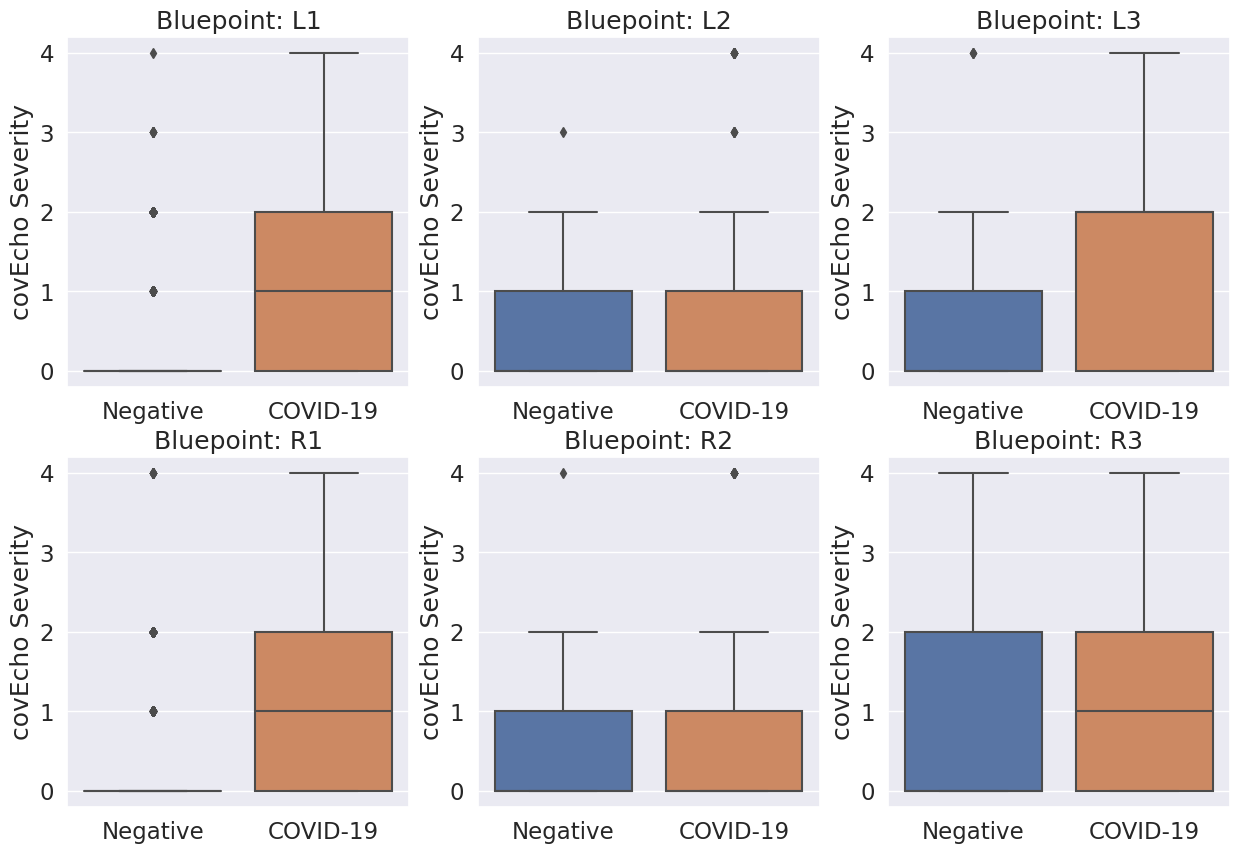

In [32]:
#set seaborn plotting aesthetics as default
sns.set(font_scale=1.5)
#define plotting region 
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i, bp in enumerate(bluepoints):
    # Filter the data
    bp_df = severity_filtered[severity_filtered.Bluepoint == bp]
    # Plot the data
    print(f"Bluepoint {bp} has {bp_df.shape[0]} frames")
    sns.boxplot(data=bp_df, x="COVID19", y="yolo_severity_score", ax=axes[i//3, i%3])
    axes[i//3, i%3].set_title(f"Bluepoint: {bp}")
    axes[i//3, i%3].set_xlabel("")
    axes[i//3, i%3].set_ylabel("covEcho Severity")
    axes[i//3, i%3].set_xticklabels(["Negative", "COVID-19"])
    
plt.show()

/tmp/ipykernel_1263/67030532.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  severity_filtered["Bluepoint_bilateral"] = severity_filtered["Bluepoint"].apply(lambda x: x[1])


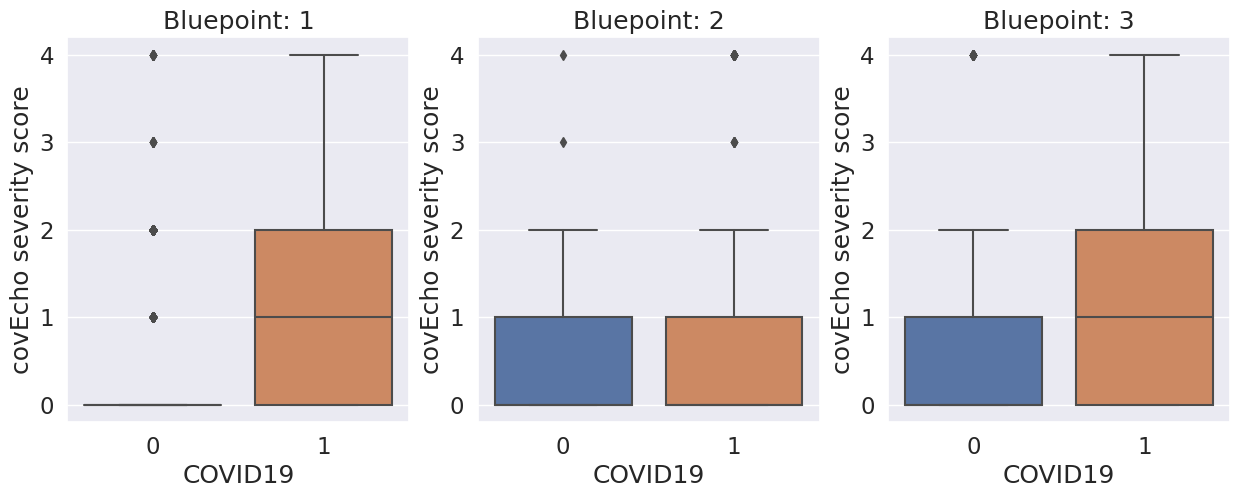

In [33]:
# Assigning L1 and R1 to the bilateral bluepoint "1", L2 and R2 to "2" and L3 and R3 to "3" for aggregated plotting
severity_filtered["Bluepoint_bilateral"] = severity_filtered["Bluepoint"].apply(lambda x: x[1])

# 3 subplots with scatter plot for each bluepoint BMI against std of severity score
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, bp in enumerate(["1", "2", "3"]):
    # Filter the data
    bp_df = severity_filtered[severity_filtered.Bluepoint_bilateral == bp]
    # Plot the data
    sns.boxplot(data=bp_df, x="COVID19", y="yolo_severity_score", ax=axes[i])
    axes[i].set_title(f"Bluepoint: {bp}")
    axes[i].set_xlabel("COVID19")
    axes[i].set_ylabel("covEcho severity score")

plt.show()

Question: How to statistically verify this observation? Mean distance between cov+ and -? Only one value (2 at max if both sides) per bp. How to compare them?

### BMI Test
Test Ronalds hypothesis that the BMI influences ability to get good pictures and might in turn increase score variance.

In [34]:
all_clinical_vars = get_clinical_df()

bmi_clinical = all_clinical_vars[["Video ID", "pat_bmi"]]
bmi_clinical = bmi_clinical.rename(columns={"pat_bmi": "BMI", "Video ID": "Patient ID"})
bmi_hypothesis_df = yolo_detection_df[["Frame", "Patient ID", "Bluepoint", "yolo_severity_score", "manual_severity_score", "COVID19"]].drop_duplicates().reset_index(drop=True)
# Drop all frames with yolo_severity_score < 0
bmi_hypothesis_df = bmi_hypothesis_df[bmi_hypothesis_df.yolo_severity_score >= 0]

In [35]:
# Group by patient and bluepoint
bmi_bluepoint_grouped = bmi_hypothesis_df.groupby(["Patient ID", "Bluepoint"]).agg({"yolo_severity_score": "std", "manual_severity_score": "std", "COVID19": "first"}).reset_index()
bmi_patient_grouped = bmi_hypothesis_df.groupby(["Patient ID"]).agg({"yolo_severity_score": "std", "manual_severity_score": "std", "COVID19": "first"}).reset_index()
# Rename columns to std
bmi_bluepoint_grouped = bmi_bluepoint_grouped.rename(columns={"yolo_severity_score": "yolo_severity_score_std", "manual_severity_score": "manual_severity_score_std"})
bmi_patient_grouped = bmi_patient_grouped.rename(columns={"yolo_severity_score": "yolo_severity_score_std", "manual_severity_score": "manual_severity_score_std"})
# Merge with clinical data
bmi_bluepoint_grouped = bmi_bluepoint_grouped.merge(bmi_clinical, on="Patient ID")
bmi_patient_grouped = bmi_patient_grouped.merge(bmi_clinical, on="Patient ID")
bmi_bluepoint_grouped.head()

,Patient ID,Bluepoint,yolo_severity_score_std,manual_severity_score_std,COVID19,BMI
0,A001,L1,0.0,0.0,0,30.49
1,A001,L2,0.0,0.0,0,30.49
2,A001,L3,0.0,0.0,0,30.49
3,A001,R1,0.0,0.0,0,30.49
4,A001,R2,0.0,0.0,0,30.49


#### Test yolo_severity_score

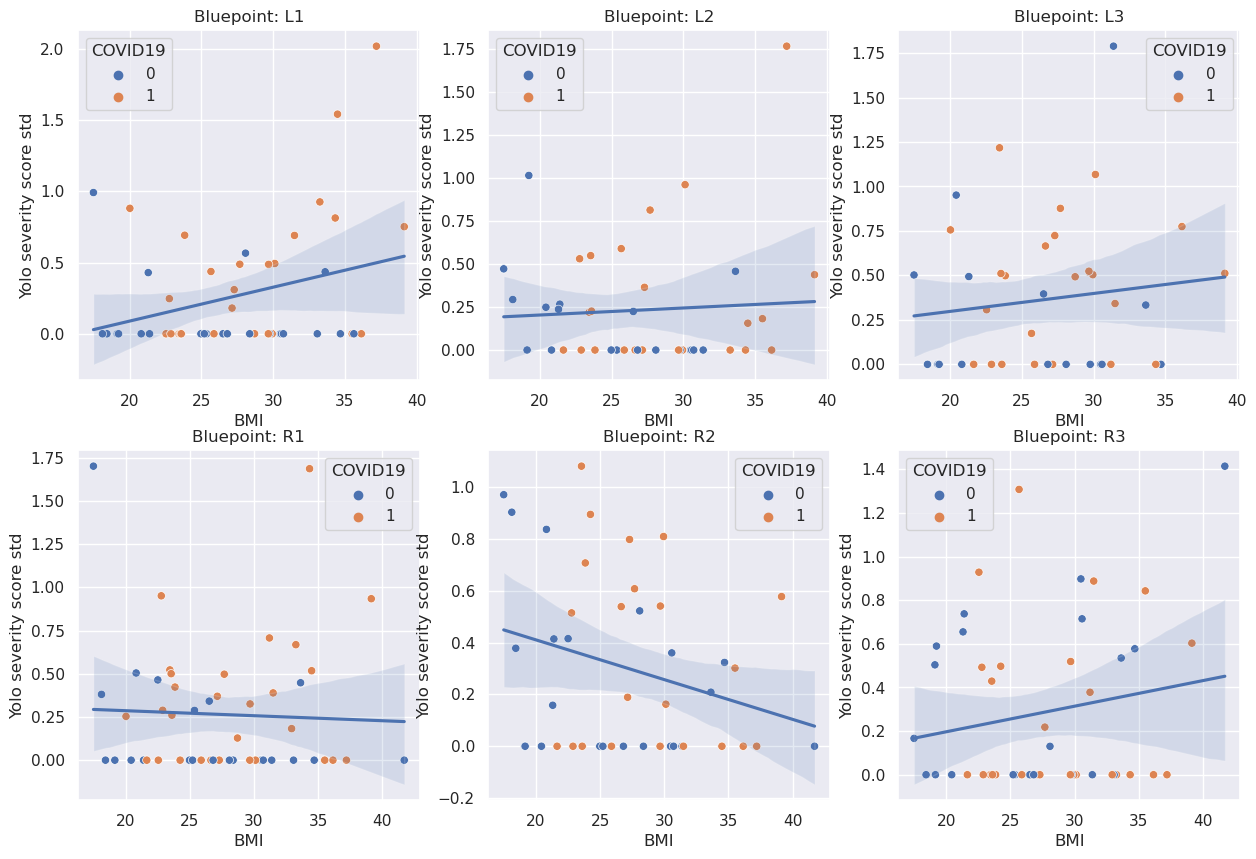

In [36]:
# Scatter plot for each bluepoint BMI against std of severity score
#set seaborn plotting aesthetics as default
sns.set()
#define plotting region
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i, bp in enumerate(bluepoints):
    # Filter the data
    bp_df = bmi_bluepoint_grouped[bmi_bluepoint_grouped.Bluepoint == bp]
    # Plot the data
    sns.scatterplot(data=bp_df, x="BMI", y="yolo_severity_score_std", hue="COVID19", ax=axes[i//3, i%3])
    # Add regression line
    sns.regplot(data=bp_df, x="BMI", y="yolo_severity_score_std", ax=axes[i//3, i%3], scatter=False)
    axes[i//3, i%3].set_title(f"Bluepoint: {bp}")
    axes[i//3, i%3].set_xlabel("BMI")
    axes[i//3, i%3].set_ylabel("Yolo severity score std")

plt.show()

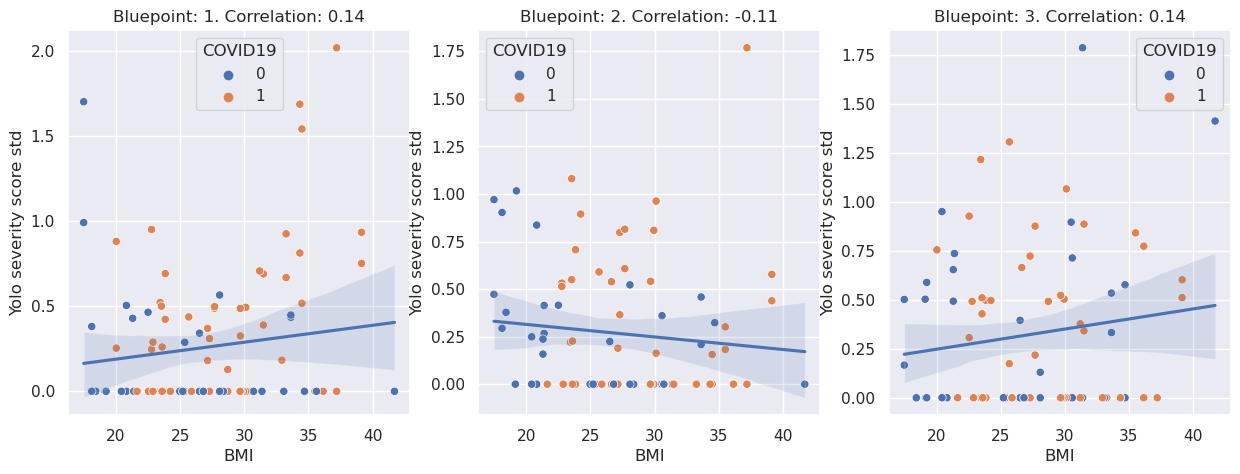

In [37]:
# Aggregate Bluepoints
# Assigning L1 and R1 to the bilateral bluepoint "1", L2 and R2 to "2" and L3 and R3 to "3" for aggregated plotting
bmi_bluepoint_grouped["Bluepoint_bilateral"] = bmi_bluepoint_grouped["Bluepoint"].apply(lambda x: x[1])

# 3 subplots with scatter plot for each bluepoint BMI against std of severity score
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, bp in enumerate(["1", "2", "3"]):
    # Filter the data
    bp_df = bmi_bluepoint_grouped[bmi_bluepoint_grouped.Bluepoint_bilateral == bp]
    # Plot the data
    sns.scatterplot(data=bp_df, x="BMI", y="yolo_severity_score_std", hue="COVID19", ax=axes[i])
    # Add regression line
    sns.regplot(data=bp_df, x="BMI", y="yolo_severity_score_std", ax=axes[i], scatter=False)
    # Calculate correlation
    corr = bp_df.yolo_severity_score_std.corr(bp_df.BMI)
    axes[i].set_title(f"Bluepoint: {bp}. Correlation: {corr:.2f}")
    axes[i].set_xlabel("BMI")
    axes[i].set_ylabel("Yolo severity score std")

plt.show()

The crucial plot leading us to reject the BMI hypothesis. The BMI does not seem to influence the variance of the severity scores, especially not for BP 2 and 3 which we would have expected to be the most affected by a higher BMI.

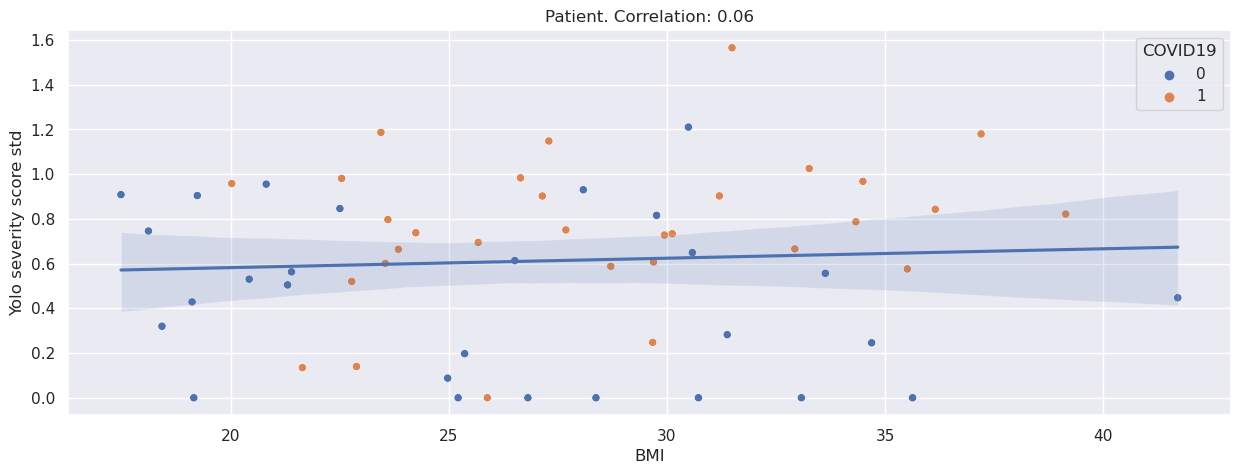

In [38]:
fig, axes = plt.subplots(1, 1, figsize=(15, 5))

# Plot the data
sns.scatterplot(data=bmi_patient_grouped, x="BMI", y="yolo_severity_score_std", hue="COVID19", ax=axes)
# Add regression line
sns.regplot(data=bmi_patient_grouped, x="BMI", y="yolo_severity_score_std", ax=axes, scatter=False)
# Calculate correlation
corr = bmi_patient_grouped.yolo_severity_score_std.corr(bmi_patient_grouped.BMI)

axes.set_title(f"Patient. Correlation: {corr:.2f}")
axes.set_xlabel("BMI")
axes.set_ylabel("Yolo severity score std")

plt.show()

#### Test manual_severity_score

For manual severity scores the Intra-Bluepoint variance does not make sense because there is only one score per video.

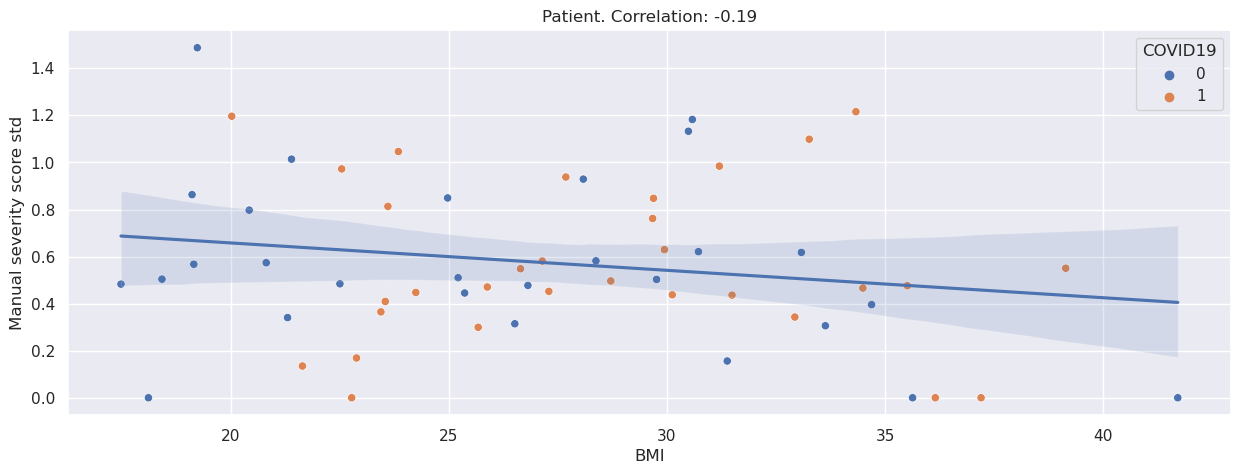

In [39]:
fig, axes = plt.subplots(1, 1, figsize=(15, 5))

# Plot the data
sns.scatterplot(data=bmi_patient_grouped, x="BMI", y="manual_severity_score_std", hue="COVID19", ax=axes)
# Add regression line
sns.regplot(data=bmi_patient_grouped, x="BMI", y="manual_severity_score_std", ax=axes, scatter=False)
# Calculate correlation
corr = bmi_patient_grouped.manual_severity_score_std.corr(bmi_patient_grouped.BMI)

axes.set_title(f"Patient. Correlation: {corr:.2f}")
axes.set_xlabel("BMI")
axes.set_ylabel("Manual severity score std")

plt.show()

### Different BMI approach. Correlate the error of the severity score with the BMI

In [40]:
all_clinical_vars = get_clinical_df()

bmi_clinical = all_clinical_vars[["Video ID", "pat_bmi"]]
bmi_clinical = bmi_clinical.rename(columns={"pat_bmi": "BMI", "Video ID": "Patient ID"})
bmi_hypothesis_df = yolo_detection_df[["Frame", "Patient ID", "Bluepoint", "yolo_severity_score", "manual_severity_score", "COVID19"]].drop_duplicates().reset_index(drop=True)
# Drop all frames with yolo_severity_score < 0
bmi_hypothesis_df = bmi_hypothesis_df[bmi_hypothesis_df.yolo_severity_score >= 0]
bmi_hypothesis_df = bmi_hypothesis_df.merge(bmi_clinical, on="Patient ID")
bmi_hypothesis_df.head()

,Frame,Patient ID,Bluepoint,yolo_severity_score,manual_severity_score,COVID19,BMI
0,10,A009,R3,0.0,0.0,0,25.36
1,17,A009,R3,0.0,0.0,0,25.36
2,18,A009,R3,0.0,0.0,0,25.36
3,19,A009,R3,0.0,0.0,0,25.36
4,20,A009,R3,0.0,0.0,0,25.36


In [41]:
# Assume severtiy_score > 0 is COVID19. Create prediction column
bmi_hypothesis_df["yolo_prediction"] = bmi_hypothesis_df["yolo_severity_score"].apply(lambda x: 1 if x > 0 else 0)
bmi_hypothesis_df["manual_prediction"] = bmi_hypothesis_df["manual_severity_score"].apply(lambda x: 1 if x > 0 else 0)
# Create a column for the error between the prediction and the actual value
bmi_hypothesis_df["yolo_prediction_err"] = abs(bmi_hypothesis_df["yolo_prediction"] - bmi_hypothesis_df["COVID19"])
bmi_hypothesis_df["manual_prediction_err"] = abs(bmi_hypothesis_df["manual_prediction"] - bmi_hypothesis_df["COVID19"])

bmi_bluepoint_grouped = bmi_hypothesis_df.groupby(["Patient ID", "Bluepoint"]).agg({"yolo_prediction_err": "mean", "manual_prediction_err": "mean", "COVID19": "first", "BMI": "first"}).reset_index()
bmi_bluepoint_grouped.head()

,Patient ID,Bluepoint,yolo_prediction_err,manual_prediction_err,COVID19,BMI
0,A001,L1,1.0,1.0,0,30.49
1,A001,L2,0.0,1.0,0,30.49
2,A001,L3,1.0,1.0,0,30.49
3,A001,R1,0.0,1.0,0,30.49
4,A001,R2,1.0,1.0,0,30.49


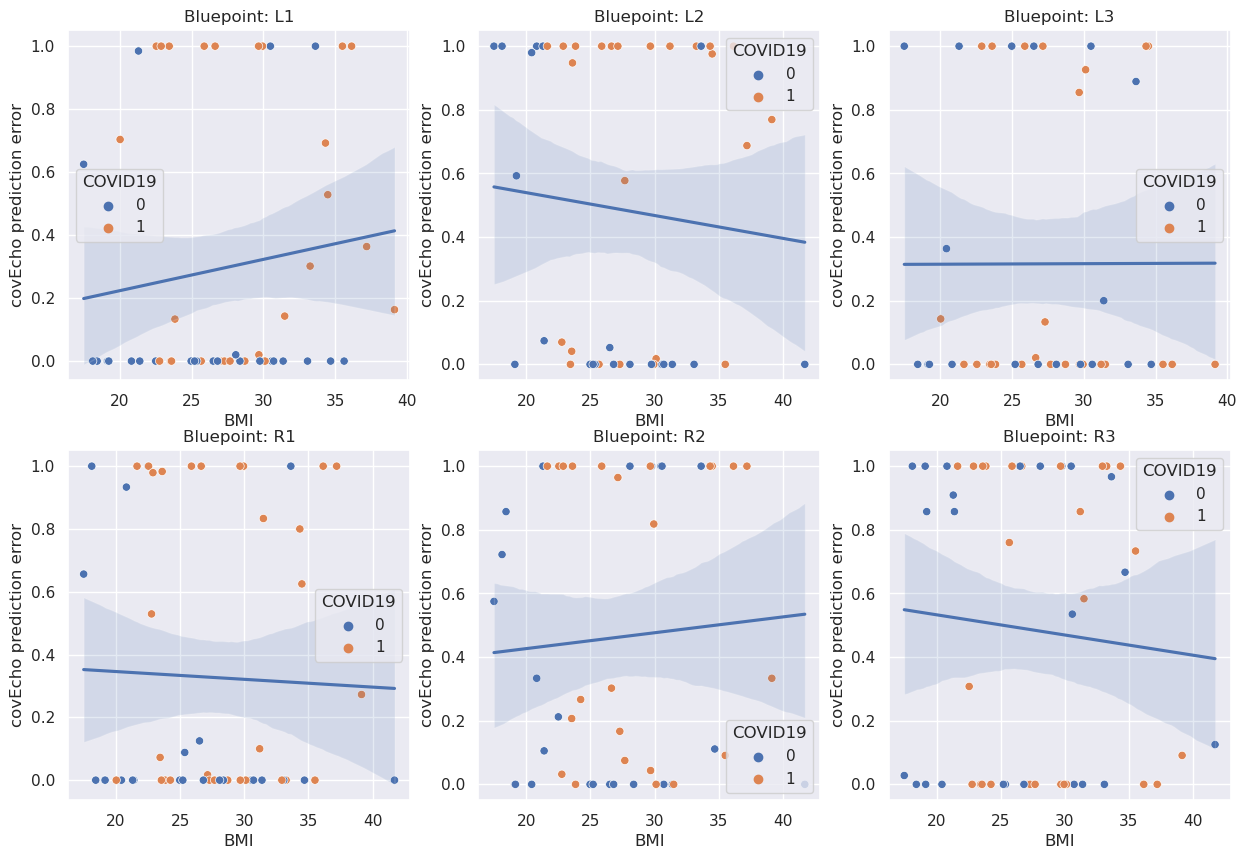

In [42]:
# Scatter plot for each bluepoint BMI against prediction error
#define plotting region
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i, bp in enumerate(bluepoints):
    # Filter the data
    bp_df = bmi_bluepoint_grouped[bmi_bluepoint_grouped.Bluepoint == bp]
    # Plot the data
    sns.scatterplot(data=bp_df, x="BMI", y="yolo_prediction_err", hue="COVID19", ax=axes[i//3, i%3])
    # Add regression line
    sns.regplot(data=bp_df, x="BMI", y="yolo_prediction_err", ax=axes[i//3, i%3], scatter=False)
    axes[i//3, i%3].set_title(f"Bluepoint: {bp}")
    axes[i//3, i%3].set_xlabel("BMI")
    axes[i//3, i%3].set_ylabel("covEcho prediction error")

plt.show()

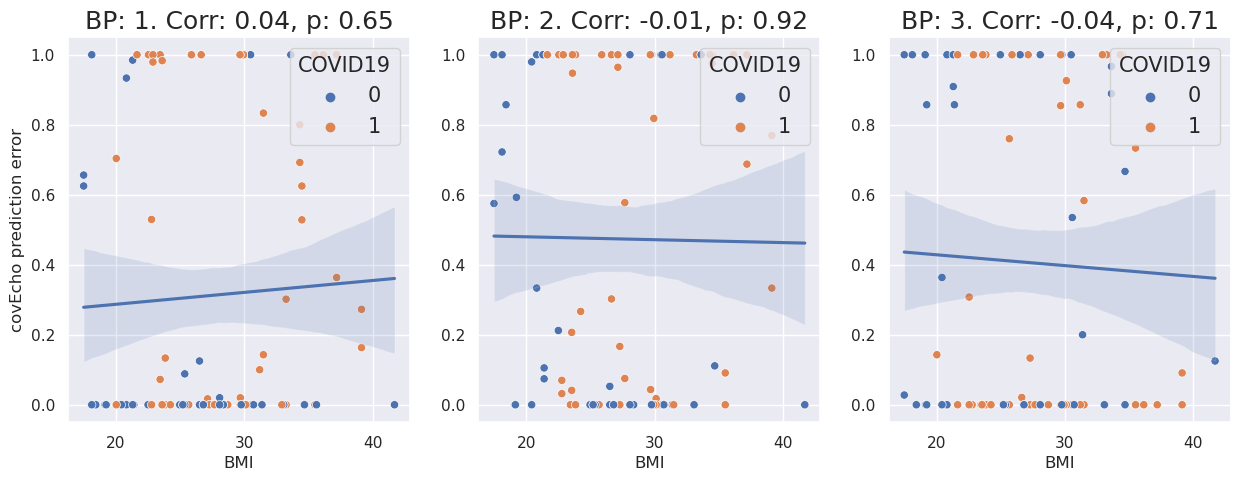

In [43]:
import scipy.stats as stats
# Aggregate Bluepoints
# Assigning L1 and R1 to the bilateral bluepoint "1", L2 and R2 to "2" and L3 and R3 to "3" for aggregated plotting
bmi_bluepoint_grouped["Bluepoint_bilateral"] = bmi_bluepoint_grouped["Bluepoint"].apply(lambda x: x[1])
# Drop rows with nan values
bmi_bluepoint_grouped = bmi_bluepoint_grouped.dropna()

# 3 subplots with scatter plot for each bluepoint BMI against prediction error
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.set(font_scale=1.5)

for i, bp in enumerate(["1", "2", "3"]):
    # Filter the data
    bp_df = bmi_bluepoint_grouped[bmi_bluepoint_grouped.Bluepoint_bilateral == bp]
    # Plot the data
    sns.scatterplot(data=bp_df, x="BMI", y="yolo_prediction_err", hue="COVID19", ax=axes[i])
    # Add regression line
    sns.regplot(data=bp_df, x="BMI", y="yolo_prediction_err", ax=axes[i], scatter=False)
    # Calculate pearson correlation
    corr, p = stats.pearsonr(bp_df.BMI, bp_df.yolo_prediction_err)
    axes[i].set_title(f"BP: {bp}. Corr: {corr:.2f}, p: {p:.2f}")
    axes[i].set_xlabel("BMI")
    #axes[i].set_ylabel("covEcho prediction error")
    if i == 0:
        axes[i].set_ylabel("covEcho prediction error")
    else:
        axes[i].set_ylabel("")
    # Fix legend top right corner
    axes[i].legend(loc='upper right', fontsize='small', title_fontsize='small')
    # Set legend titel to "COVID19"
    axes[i].get_legend().set_title("COVID19")
    # Reduce y tick font size
    #axes[i].tick_params(axis='y', labelsize=12)

plt.show()

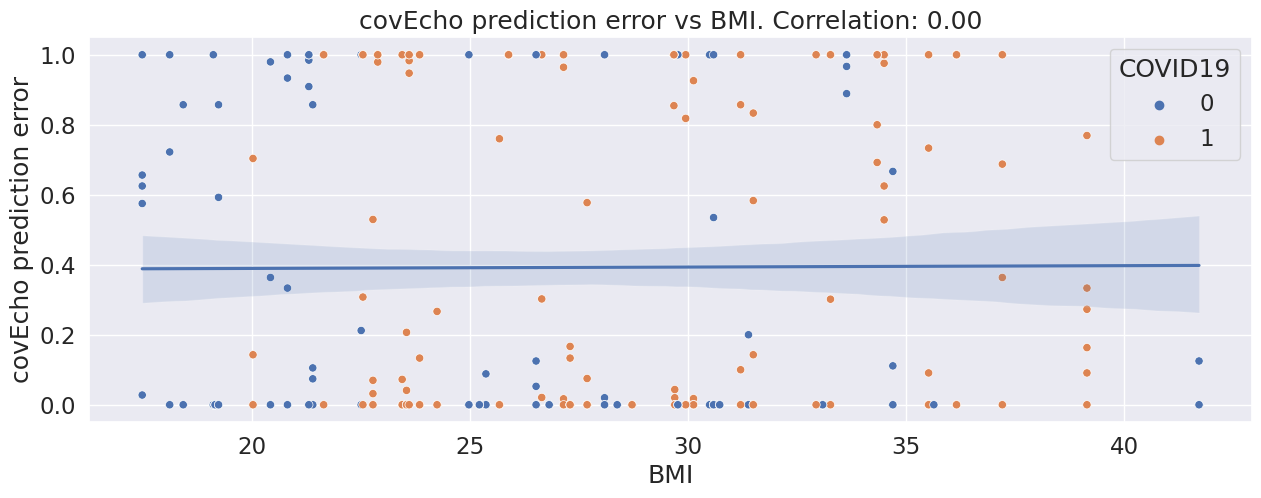

In [44]:
# Group by Patient ID and Bluepoint and get the mean error and the first value of severity score
bmi_hypothesis_df_patient = bmi_hypothesis_df.groupby(["Patient ID", "Bluepoint"]).agg({"yolo_prediction_err": "mean", "manual_prediction_err": "mean", "yolo_severity_score": "first", "manual_severity_score": "first", "COVID19": "first", "BMI": "first"}).reset_index()

# Plot yolo_prediction_err against BMI
fig, axes = plt.subplots(1, 1, figsize=(15, 5))

# Plot the data
sns.scatterplot(data=bmi_hypothesis_df_patient, x="BMI", y="yolo_prediction_err", hue="COVID19", ax=axes)
# Add regression line
sns.regplot(data=bmi_hypothesis_df_patient, x="BMI", y="yolo_prediction_err", ax=axes, scatter=False)
# Calculate correlation
corr = bmi_hypothesis_df_patient.yolo_prediction_err.corr(bmi_hypothesis_df_patient.BMI)
axes.set_title(f"covEcho prediction error vs BMI. Correlation: {corr:.2f}")
axes.set_xlabel("BMI")
axes.set_ylabel("covEcho prediction error")

plt.show()

In [45]:
for bp in bluepoints:
    if bp == "None":
        continue
    corr_cov = severity_filtered[severity_filtered.Bluepoint == bp].yolo_severity_score.corr(severity_filtered[severity_filtered.Bluepoint == bp].COVID19)
    # Spearman correlation
    corr_spearman = severity_filtered[severity_filtered.Bluepoint == bp].yolo_severity_score.corr(severity_filtered[severity_filtered.Bluepoint == bp].COVID19, method="spearman")
    print(f"Bluepoint: {bp}\tCorr: {corr_spearman:.2f}")

Bluepoint: L1	Corr: 0.39
Bluepoint: L2	Corr: 0.08
Bluepoint: L3	Corr: 0.28
Bluepoint: R1	Corr: 0.30
Bluepoint: R2	Corr: 0.03
Bluepoint: R3	Corr: 0.14


Very interesting plots of the Bluepoints. It seems like L1 and R1 are significantly more related to COVID than the rest.

In [46]:
bp_left = severity_filtered[severity_filtered.Bluepoint.isin(["L1", "L2", "L3"])].yolo_severity_score
bp_right = severity_filtered[severity_filtered.Bluepoint.isin(["R1", "R2", "R3"])].yolo_severity_score

bp_1 = severity_filtered[severity_filtered.Bluepoint.isin(["L1", "R1"])].yolo_severity_score
bp_2 = severity_filtered[severity_filtered.Bluepoint.isin(["L2", "R2"])].yolo_severity_score
bp_3 = severity_filtered[severity_filtered.Bluepoint.isin(["L3", "R3"])].yolo_severity_score

p_values = []

# Mann-Whitney U-Test
stat, p_value = mannwhitneyu(bp_left, bp_right)
p_values.append(p_value)
print("Bluepoint left vs right")
print(f"Mann–Whitney U Test: statistic={stat:.4f}, p-value={p_value:.4f}")
print(f"Mean severity left: {bp_left.mean():.4f}")
print(f"Mean severity right: {bp_right.mean():.4f}")

print("")
print("Bluepoint 1 vs 2 vs 3")
print("1 vs 2")
stat, p_value = mannwhitneyu(bp_1, bp_2)
p_values.append(p_value)
print(f"Mann–Whitney U Test: statistic={stat:.4f}, p-value={p_value:.4f}")
print("2 vs 3")
stat, p_value = mannwhitneyu(bp_2, bp_3)
p_values.append(p_value)
print(f"Mann–Whitney U Test: statistic={stat:.4f}, p-value={p_value:.4f}")
print("1 vs 3")
stat, p_value = mannwhitneyu(bp_1, bp_3)
p_values.append(p_value)
print(f"Mann–Whitney U Test: statistic={stat:.4f}, p-value={p_value:.4f}")

print("\nMeans:")
print(f"Mean severity 1: {bp_1.mean():.4f}")
print(f"Mean severity 2: {bp_2.mean():.4f}")
print(f"Mean severity 3: {bp_3.mean():.4f}")


# Using bonferonni correction for multiple comparisons
from statsmodels.sandbox.stats.multicomp import multipletests
p_adjusted = multipletests(p_values, method='bonferroni')

print("Bonferroni corrected p-values:")

test_distributions = ["L vs R", "1 vs 2", "2 vs 3", "1 vs 3"]
# Print green if p-value is significant otherwise red
for i, p in enumerate(p_adjusted[1]):
    if p < 0.05:
        print(f"\033[92m{test_distributions[i]}: {p:.4f}\033[0m")
    else:
        print(f"\033[91m{test_distributions[i]}: {p:.4f}\033[0m")

Bluepoint left vs right
Mann–Whitney U Test: statistic=16256609.5000, p-value=0.0000
Mean severity left: 0.8249
Mean severity right: 0.7263

Bluepoint 1 vs 2 vs 3
1 vs 2
Mann–Whitney U Test: statistic=8881962.0000, p-value=0.0000
2 vs 3
Mann–Whitney U Test: statistic=3865206.0000, p-value=0.0000
1 vs 3
Mann–Whitney U Test: statistic=6171886.0000, p-value=0.0000

Means:
Mean severity 1: 0.7488
Mean severity 2: 0.5821
Mean severity 3: 1.0575
Bonferroni corrected p-values:
L vs R: 0.0000
1 vs 2: 0.0000
2 vs 3: 0.0000
1 vs 3: 0.0000


The density plot shows the same picture. A lot better separation along the severiy score. 

Inspired by this result check the predictive performance of the severity score per bluepoint.

In [47]:
import statistics as logit_stats
from importlib import reload
reload(logit_stats)

# Evaluate the logits of the YOLONet for all bluepoints
gt = severity_filtered["COVID19"].values
predictions = (severity_filtered["yolo_severity_score"] >= 1).astype(int).values

eval = logit_stats.evaluate_logits(gt, predictions, CLASSES=["No COVID", "COVID"])
eval = pd.concat([eval], keys=["All"], names=['Bluepoint'])

In [48]:
eval_bp = eval
for bp in bluepoints:
    if bp == "None": continue
    bp_df = severity_filtered[severity_filtered.Bluepoint == bp]
    gt = bp_df["COVID19"].values
    predictions = (bp_df["yolo_severity_score"] >= 1).astype(int).values
    temp = logit_stats.evaluate_logits(gt, predictions, CLASSES=["No COVID", "COVID"])
    temp = pd.concat([temp], keys=[bp], names=['Bluepoint'])
    eval_bp = pd.concat([eval_bp, temp])

def highlight_max(s):
    is_max = s == s.max()
    return ['color: green' if cell else '' for cell in is_max]

eval_bp.style.background_gradient().apply(highlight_max)

In [49]:
# latex = eval_bp.drop(columns=["specificity", "precision", "recall", "accuracy", "f1-score", "mcc"])
# print(latex.reset_index().drop(columns=["level_1"]).drop_duplicates().rename(columns={"balanced": "Balanced Accuracy"}).to_latex(index=False, float_format="%.2f"))

L1 seems to be over all the best performing bp. R1 is similarly prominent.

### Blue point analysis on manual severity labels

In [50]:
severity_filtered_manual = severity_filtered[["Patient ID", "COVID19", "manual_severity_score", "Bluepoint"]]
severity_filtered_manual = severity_filtered_manual.dropna()
severity_filtered_manual = severity_filtered_manual.drop_duplicates()
severity_filtered_manual

,Patient ID,COVID19,manual_severity_score,Bluepoint
1,A009,0,1.0,L2
2,A046,1,0.0,R1
3,A015,1,0.0,R1
4,A046,1,1.0,R2
5,A046,1,1.0,R3
...,...,...,...,...
12525,A040,0,2.0,L2
12625,A040,0,2.0,L1
12779,A042,0,1.0,R2
12821,A028,0,2.0,L3


Bluepoint L1 has 57 values
Bluepoint L2 has 48 values
Bluepoint L3 has 47 values
Bluepoint R1 has 57 values
Bluepoint R2 has 50 values
Bluepoint R3 has 54 values


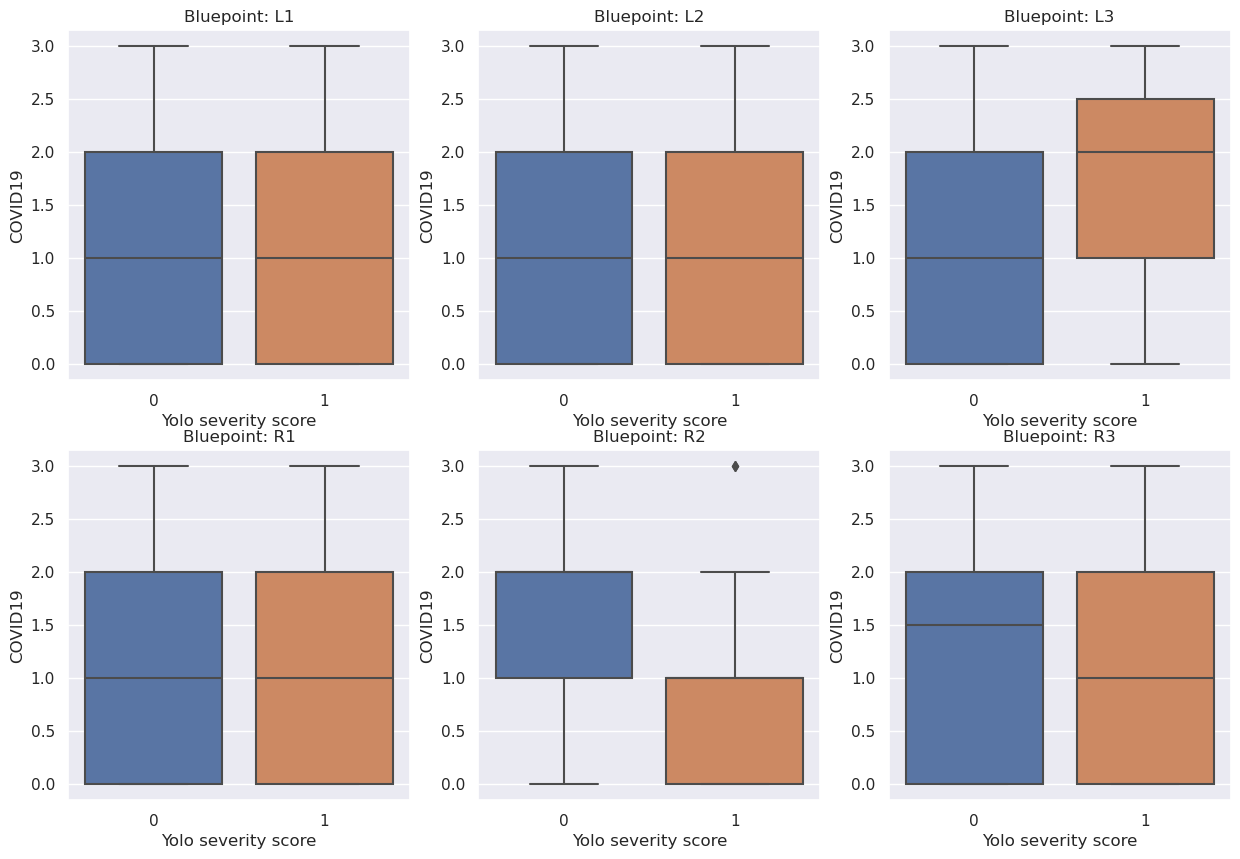

In [51]:
#set seaborn plotting aesthetics as default
sns.set()
#define plotting region 
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i, bp in enumerate(bluepoints):
    # Filter the data
    bp_df = severity_filtered_manual[severity_filtered_manual.Bluepoint == bp]
    # Plot the data
    print(f"Bluepoint {bp} has {bp_df.shape[0]} values")
    sns.boxplot(data=bp_df, x="COVID19", y="manual_severity_score", ax=axes[i//3, i%3])
    axes[i//3, i%3].set_title(f"Bluepoint: {bp}")
    axes[i//3, i%3].set_xlabel("Yolo severity score")
    axes[i//3, i%3].set_ylabel("COVID19")
    
plt.show()

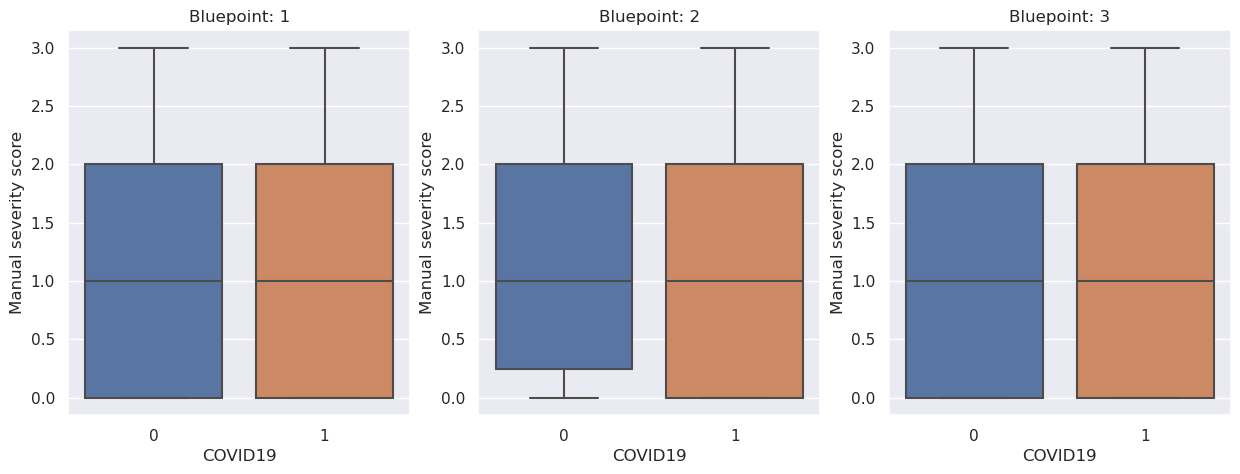

In [52]:
# Assigning L1 and R1 to the bilateral bluepoint "1", L2 and R2 to "2" and L3 and R3 to "3" for aggregated plotting
severity_filtered_manual["Bluepoint_bilateral"] = severity_filtered_manual["Bluepoint"].apply(lambda x: x[1])

# 3 subplots with scatter plot for each bluepoint BMI against std of severity score
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, bp in enumerate(["1", "2", "3"]):
    # Filter the data
    bp_df = severity_filtered_manual[severity_filtered_manual.Bluepoint_bilateral == bp]
    # Plot the data
    sns.boxplot(data=bp_df, x="COVID19", y="manual_severity_score", ax=axes[i])
    axes[i].set_title(f"Bluepoint: {bp}")
    axes[i].set_xlabel("COVID19")
    axes[i].set_ylabel("Manual severity score")

plt.show()

In [53]:
bp_left = severity_filtered_manual[severity_filtered_manual.Bluepoint.isin(["L1", "L2", "L3"])].manual_severity_score
bp_right = severity_filtered_manual[severity_filtered_manual.Bluepoint.isin(["R1", "R2", "R3"])].manual_severity_score

bp_1 = severity_filtered_manual[severity_filtered_manual.Bluepoint.isin(["L1", "R1"])].manual_severity_score
bp_2 = severity_filtered_manual[severity_filtered_manual.Bluepoint.isin(["L2", "R2"])].manual_severity_score
bp_3 = severity_filtered_manual[severity_filtered_manual.Bluepoint.isin(["L3", "R3"])].manual_severity_score

p_values = []

# Mann-Whitney U-Test
stat, p_value = mannwhitneyu(bp_left, bp_right)
p_values.append(p_value)
print("Bluepoint left vs right")
print(f"Mann–Whitney U Test: statistic={stat:.4f}, p-value={p_value:.4f}")
print(f"Mean severity left: {bp_left.mean():.4f}")
print(f"Mean severity right: {bp_right.mean():.4f}")

print("")
print("Bluepoint 1 vs 2 vs 3")
print("1 vs 2")
stat, p_value = mannwhitneyu(bp_1, bp_2)
p_values.append(p_value)
print(f"Mann–Whitney U Test: statistic={stat:.4f}, p-value={p_value:.4f}")
print("2 vs 3")
stat, p_value = mannwhitneyu(bp_2, bp_3)
p_values.append(p_value)
print(f"Mann–Whitney U Test: statistic={stat:.4f}, p-value={p_value:.4f}")
print("1 vs 3")
stat, p_value = mannwhitneyu(bp_1, bp_3)
p_values.append(p_value)
print(f"Mann–Whitney U Test: statistic={stat:.4f}, p-value={p_value:.4f}")

print("\nMeans:")
print(f"Mean severity 1: {bp_1.mean():.4f}")
print(f"Mean severity 2: {bp_2.mean():.4f}")
print(f"Mean severity 3: {bp_3.mean():.4f}")


# Using bonferonni correction for multiple comparisons
from statsmodels.sandbox.stats.multicomp import multipletests
p_adjusted = multipletests(p_values, method='bonferroni')

print("Bonferroni corrected p-values:")

test_distributions = ["L vs R", "1 vs 2", "2 vs 3", "1 vs 3"]
# Print green if p-value is significant otherwise red
for i, p in enumerate(p_adjusted[1]):
    if p < 0.05:
        print(f"\033[92m{test_distributions[i]}: {p:.4f}\033[0m")
    else:
        print(f"\033[91m{test_distributions[i]}: {p:.4f}\033[0m")

Bluepoint left vs right
Mann–Whitney U Test: statistic=12691.0000, p-value=0.5541
Mean severity left: 1.2237
Mean severity right: 1.1366

Bluepoint 1 vs 2 vs 3
1 vs 2
Mann–Whitney U Test: statistic=5580.0000, p-value=0.9897
2 vs 3
Mann–Whitney U Test: statistic=4660.0000, p-value=0.4598
1 vs 3
Mann–Whitney U Test: statistic=5430.5000, p-value=0.4563

Means:
Mean severity 1: 1.1404
Mean severity 2: 1.1327
Mean severity 3: 1.2673
Bonferroni corrected p-values:
L vs R: 1.0000
1 vs 2: 1.0000
2 vs 3: 1.0000
1 vs 3: 1.0000


# Class area analysis

In [54]:
# Add class count, weightes class count and weighted class area by confidence
yolo_detection_df["area_weighted"] = yolo_detection_df["area"] * yolo_detection_df["confidence"]
grp = yolo_detection_df.groupby(["video_name", "class"])
video_lvl = grp.agg({"class": "count", "confidence": "sum", "area": "sum", "area_weighted": "sum"})
video_lvl = video_lvl.rename(columns={"class": "class_count", "confidence": "class_count_conf_weighted", "area": "area", "area_weighted": "area_conf_weighted"}).reset_index()

# Add frame count
frame_count_per_video = yolo_detection_df[["video_name", "Frame"]].drop_duplicates().groupby(["video_name"]).count().reset_index().rename(columns={"Frame": "Frame_count"})
video_lvl = pd.merge(video_lvl, frame_count_per_video, on="video_name")


# Devide by frame count to account for different video lengths
video_lvl["area"] = video_lvl["area"] / video_lvl["Frame_count"]
video_lvl["area_conf_weighted"] = video_lvl["area_conf_weighted"] / video_lvl["Frame_count"]
video_lvl["class_count"] = video_lvl["class_count"] / video_lvl["Frame_count"]
video_lvl["class_count_conf_weighted"] = video_lvl["class_count_conf_weighted"] / video_lvl["Frame_count"]

# Add classes with 0 area
possible_classes = list(range(len(class_names)))
video_names = yolo_detection_df.video_name.unique().tolist()
from itertools import product
idx_df =  pd.DataFrame(list(product(possible_classes,video_names))).rename(columns={0:'class',1:'video_name'})

video_lvl = pd.merge(idx_df, video_lvl, on=["video_name", "class"], how="left").fillna(0).sort_values(by=["video_name", "class"])

video_lvl["class_name"] = video_lvl["class"].map(lambda x: class_names[x])

patient_data = yolo_detection_df.groupby(["Patient ID", "video_name"]).agg({"COVID19": "first","Bluepoint": "first", "yolo_severity_score": "mean", "manual_severity_score" : "first"}).reset_index()
video_level = pd.merge(video_lvl, patient_data, on="video_name").sort_values(by=["Patient ID", "Bluepoint", "class"]).reset_index(drop=True)
# Reorder columns
video_level = video_level[["Patient ID", "COVID19", "Bluepoint", "video_name", "yolo_severity_score", "manual_severity_score", "class", "class_name", "class_count", "class_count_conf_weighted", "area", "area_conf_weighted"]]
video_level.head(10)

,Patient ID,COVID19,Bluepoint,video_name,yolo_severity_score,manual_severity_score,class,class_name,class_count,class_count_conf_weighted,area,area_conf_weighted
0,A001,0,L1,image_147763479101025,2.000000,3.0,0,Airbronchograms,0.000000,0.000000,0.000000,0.000000
1,A001,0,L1,image_147763479101025,2.000000,3.0,1,Alines,0.000000,0.000000,0.000000,0.000000
2,A001,0,L1,image_147763479101025,2.000000,3.0,2,Blines,0.000000,0.000000,0.000000,0.000000
3,A001,0,L1,image_147763479101025,2.000000,3.0,3,Bpatch,1.403846,0.555717,0.200159,0.079026
4,A001,0,L1,image_147763479101025,2.000000,3.0,4,Consolidations,0.000000,0.000000,0.000000,0.000000
5,A001,0,L1,image_147763479101025,2.000000,3.0,5,Pleura,1.769231,0.905707,0.020921,0.010964
6,A001,0,L1,image_147763479101025,2.000000,3.0,6,Rib,0.019231,0.006544,0.000277,0.000094
7,A001,0,L1,image_147763479101025,2.000000,3.0,7,Shadow,0.000000,0.000000,0.000000,0.000000
8,A001,0,L2,image_147814256633037,-0.592593,3.0,0,Airbronchograms,0.000000,0.000000,0.000000,0.000000
9,A001,0,L2,image_147814256633037,-0.592593,3.0,1,Alines,0.333333,0.110452,0.003914,0.001286


In [55]:
# Adding information whether class is pathological or not. For now I assume class 0, 2, 3 and 4 are pathological
# Class names: ['0: Airbronchograms', '1: Alines', '2: Blines', '3: Bpatch', '4: Consolidations', '5: Pleura', '6: Rib', '7: Shadow']
pathological_classes = [0, 2, 3, 4]
non_pathological_classes = [1, 5, 6, 7]
pathological_class_names = [class_names[x] for x in pathological_classes]
non_pathological_class_names = [class_names[x] for x in non_pathological_classes]

Class count
COVID19 vs non-COVID19
Mann–Whitney U Test: statistic=234789.0000, p-value=0.0000
Significant difference
Area
COVID19 vs non-COVID19 
Mann–Whitney U Test: statistic=234871.0000, p-value=0.0000
Significant difference
Means:
Mean class count COVID19: 0.1283
Mean class count non-COVID19: 0.0726
Mean area COVID19: 0.0148
Mean area non-COVID19: 0.0076


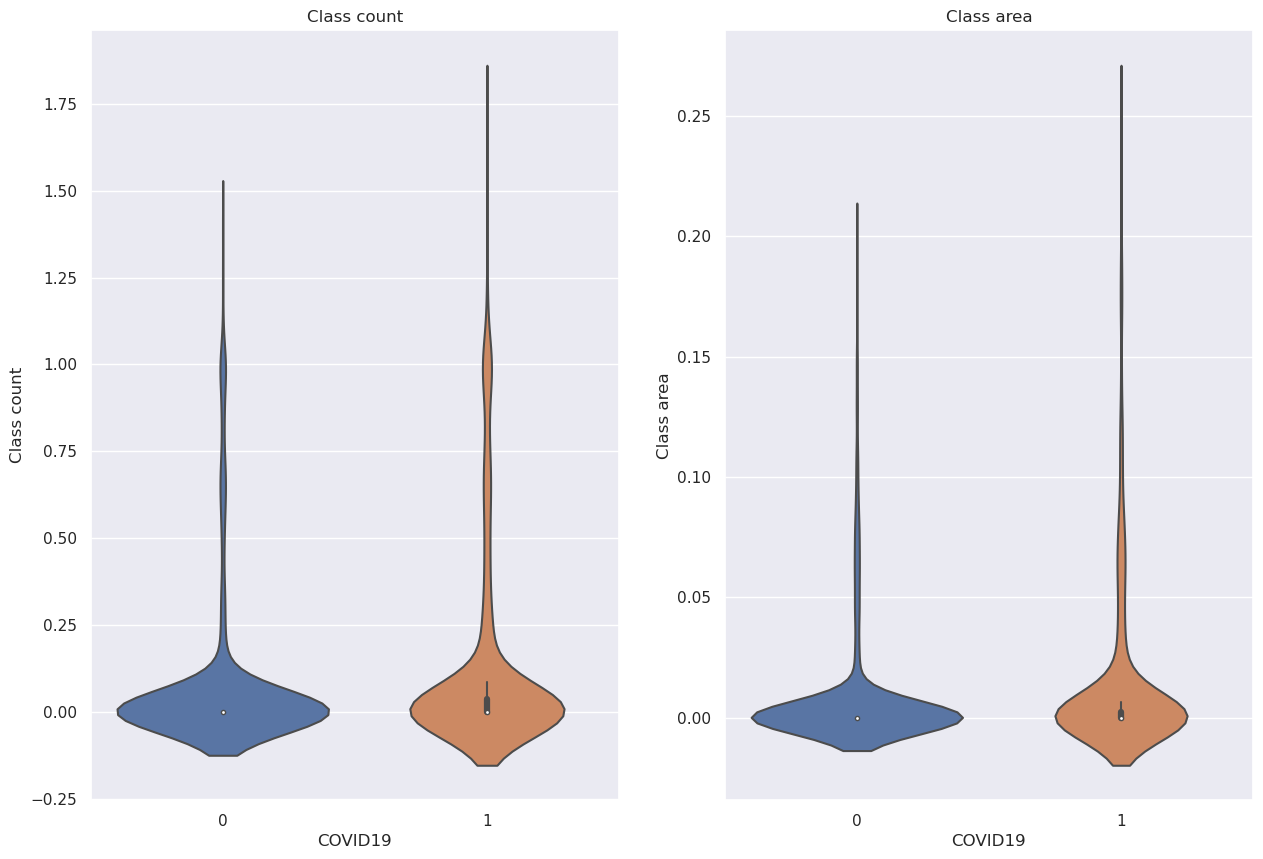

In [56]:
pathological_classes_df = video_level[video_level["class"].isin(pathological_classes)]

# perform statistical tests
print("Class count")
print("COVID19 vs non-COVID19")
stat, p_value = mannwhitneyu(pathological_classes_df[pathological_classes_df["COVID19"] == 1]["class_count"], pathological_classes_df[pathological_classes_df["COVID19"] == 0]["class_count"])
print(f"Mann–Whitney U Test: statistic={stat:.4f}, p-value={p_value:.4f}")
# Print green if p-value is significant otherwise red
if p_value < 0.05:
    print("\033[92mSignificant difference\033[0m")
else:
    print("\033[91mNo significant difference\033[0m")
print("Area")
print("COVID19 vs non-COVID19 ")
stat, p_value = mannwhitneyu(pathological_classes_df[pathological_classes_df["COVID19"] == 1]["area"], pathological_classes_df[pathological_classes_df["COVID19"] == 0]["area"])
print(f"Mann–Whitney U Test: statistic={stat:.4f}, p-value={p_value:.4f}")
# Print green if p-value is significant otherwise red
if p_value < 0.05:
    print("\033[92mSignificant difference\033[0m")
else:
    print("\033[91mNo significant difference\033[0m")

print("Means:")
print(f"Mean class count COVID19: {pathological_classes_df[pathological_classes_df['COVID19'] == 1]['class_count'].mean():.4f}")
print(f"Mean class count non-COVID19: {pathological_classes_df[pathological_classes_df['COVID19'] == 0]['class_count'].mean():.4f}")
print(f"Mean area COVID19: {pathological_classes_df[pathological_classes_df['COVID19'] == 1]['area'].mean():.4f}")
print(f"Mean area non-COVID19: {pathological_classes_df[pathological_classes_df['COVID19'] == 0]['area'].mean():.4f}")

#set seaborn plotting aesthetics as default
sns.set()
#define plotting region 
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
#plot the data
sns.violinplot(data=pathological_classes_df, x="COVID19", y="class_count", ax=axes[0])
sns.violinplot(data=pathological_classes_df, x="COVID19", y="area", ax=axes[1])

#set titles
axes[0].set_title("Class count")
axes[1].set_title("Class area")
#set y axis labels
axes[0].set_ylabel("Class count")
axes[1].set_ylabel("Class area")
    
plt.show()

To beginn we try 4 different methods to aggregate the classes over time. 
1. Simple class count per video divided by the number of frames (avrg number of classes per frame).
2. The class count weighted by the networks confidence divided by n frames.
3. The area of the detected classes summed up divided by n frames. Testing the hypothesis that the affected area has a predictive power for covid.
4. The area weighted by the networks confidence /n_Frames.

### Try different standard models using all class areas

In [57]:
import importlib
import ml_pipeline
importlib.reload(ml_pipeline)
from ml_pipeline import ModelEvaluation


Classifier = ModelEvaluation(mode="classification")

Train models on accumulated area of all detected classes:

In [58]:
# Train on all aggregation methods
agg_eval = pd.DataFrame()
agg_scores = pd.DataFrame()
agg_methods = ["area", "area_conf_weighted", "class_count", "class_count_conf_weighted"]
for agg_method in agg_methods:
    # Pivot table for regression
    class_area_per_video_pivot = video_level.pivot(index="video_name", columns="class_name", values=agg_method).reset_index()
    class_area_per_video_pivot = pd.merge(class_area_per_video_pivot, video_level[["video_name", "COVID19", "Bluepoint", "Patient ID"]], on="video_name")
    class_area_per_video_pivot = class_area_per_video_pivot.drop_duplicates().reset_index(drop=True)
    # Shuffle
    class_area_per_video_pivot = class_area_per_video_pivot.sample(frac=1, random_state=1).reset_index(drop=True)

    # Split into X and y
    X = class_area_per_video_pivot[class_names]
    y = class_area_per_video_pivot["COVID19"]
    groups = class_area_per_video_pivot["Patient ID"]

    # Train models
    scores, scores_mean = Classifier.train_models(X, y, groups=groups, plot=False)

    # Add index level to df for aggregation
    scores = pd.concat([scores], keys=[agg_method], names=['Aggregation method'])
    scores_mean = pd.concat([scores_mean], keys=[agg_method], names=['Aggregation method'])
    
    # Add to dataframe
    agg_scores = pd.concat([agg_scores, scores])
    agg_eval = pd.concat([agg_eval, scores_mean])

agg_eval.style.apply(highlight_max).format("{:.2f}")


In [59]:
# Std of scores
agg_scores.groupby(["Aggregation method", "model"]).std().style.format("{:.2f}")

In [60]:
agg_scores

fit_time  score_time  test_accuracy  \
Aggregation method                                                 
area                      0  0.005476    0.004733       0.559322   
                          1  0.005065    0.004313       0.521739   
                          2  0.005041    0.004918       0.492063   
                          3  0.004649    0.004129       0.757576   
                          4  0.004689    0.004134       0.485294   
                          0  0.018507    0.004117       0.559322   
                          1  0.015747    0.004102       0.521739   
                          2  0.012349    0.004086       0.507937   
                          3  0.013300    0.004095       0.757576   
                          4  0.008980    0.004090       0.485294   
                          0  0.118780    0.013369       0.525424   
                          1  0.122138    0.013744       0.507246   
                          2  0.117636    0.013251       0.619048   
                          3  0.118757    0.013484       0.560606   
                          4  0.118064    0.013575       0.470588   
area_conf_weighted        0  0.004452    0.004179       0.525424   
                          1  0.004287    0.004125       0.536232   
                          2  0.004277    0.004109       0.476190   
                          3  0.004419    0.004200       0.712121   
                          4  0.005228    0.004401       0.500000   
                          0  0.014267    0.004154       0.508475   
                          1  0.019500    0.004707       0.521739   
                          2  0.016917    0.004431       0.476190   
                          3  0.013863    0.004111       0.712121   
                          4  0.017371    0.004357       0.500000   
                          0  0.132218    0.013805       0.457627   
                          1  0.123765    0.013651       0.521739   
                          2  0.115714    0.013162       0.555556   
                          3  0.114911    0.013209       0.530303   
                          4  0.114754    0.013114       0.544118   
class_count               0  0.004599    0.004182       0.644068   
                          1  0.004565    0.004123       0.550725   
                          2  0.004546    0.004105       0.650794   
                          3  0.004527    0.004114       0.742424   
                          4  0.004916    0.004119       0.588235   
                          0  0.013260    0.004093       0.644068   
                          1  0.010302    0.004089       0.550725   
                          2  0.011525    0.004081       0.666667   
                          3  0.009666    0.004076       0.757576   
                          4  0.010259    0.004078       0.573529   
                          0  0.114690    0.012887       0.559322   
                          1  0.118283    0.013831       0.550725   
                          2  0.117475    0.013397       0.555556   
                          3  0.115566    0.013352       0.651515   
                          4  0.115281    0.013246       0.588235   
class_count_conf_weighted 0  0.004385    0.004133       0.593220   
                          1  0.004503    0.004097       0.492754   
                          2  0.004391    0.004091       0.587302   
                          3  0.004243    0.004104       0.712121   
                          4  0.004652    0.004107       0.573529   
                          0  0.019691    0.004079       0.593220   
                          1  0.014297    0.004126       0.507246   
                          2  0.020487    0.004074       0.587302   
                          3  0.018267    0.004090       0.696970   
                          4  0.015243    0.004082       0.558824   
                          0  0.115407    0.012934       0.559322   
                          1  0.114118    0.013095       0.637681   
                 

In [61]:
# To latex formatig .format("{:.2f}")
print(agg_eval.style.apply(highlight_max).format("{:.2f}").to_latex())

\begin{tabular}{llrrrr}
 &  & test_accuracy & test_sensitivity & test_specificity & test_f1 \\
Aggregation method & model &  &  &  &  \\
\multirow[c]{3}{*}{area} & LR & 0.56 & 0.59 & 0.57 & 0.58 \\
 & RF & 0.54 & 0.62 & 0.46 & 0.59 \\
 & SVM & 0.57 & 0.59 & 0.57 & 0.59 \\
\multirow[c]{3}{*}{area_conf_weighted} & LR & 0.55 & 0.61 & 0.51 & 0.58 \\
 & RF & 0.52 & 0.60 & 0.46 & 0.57 \\
 & SVM & 0.54 & 0.59 & 0.51 & 0.57 \\
\multirow[c]{3}{*}{class_count} & LR & 0.64 & 0.66 & 0.61 & \colorgreen 0.66 \\
 & RF & 0.58 & \colorgreen 0.69 & 0.48 & 0.63 \\
 & SVM & \colorgreen 0.64 & 0.66 & \colorgreen 0.63 & 0.66 \\
\multirow[c]{3}{*}{class_count_conf_weighted} & LR & 0.59 & 0.64 & 0.54 & 0.62 \\
 & RF & 0.58 & 0.64 & 0.54 & 0.62 \\
 & SVM & 0.59 & 0.64 & 0.54 & 0.62 \\
\end{tabular}



The models performance of 57% accuracy is not great but comparable to our first approaches of training the NN. It can't compete with the best values of the severity analysis so far.

In [62]:
# Train the best model (class_count) and save model predictions
# Pivot table for regression
class_area_per_video_pivot = video_level.pivot(index="video_name", columns="class_name", values="class_count").reset_index()
class_area_per_video_pivot = pd.merge(class_area_per_video_pivot, video_level[["video_name", "COVID19", "Bluepoint", "Patient ID"]], on="video_name")
class_area_per_video_pivot = class_area_per_video_pivot.drop_duplicates().reset_index(drop=True)
# Shuffle
class_area_per_video_pivot = class_area_per_video_pivot.sample(frac=1, random_state=1).reset_index(drop=True)

# Split into X and y
X = class_area_per_video_pivot[class_names]
y = class_area_per_video_pivot["COVID19"]
groups = class_area_per_video_pivot["Patient ID"]

# Train models
scores, scores_mean, predictions = Classifier.train_models(X, y, groups=groups, plot=False, return_model_predictions=class_area_per_video_pivot)

# Save predictions
predictions.to_csv("predictions_covEcho_class_count_video_lvl_COVID.csv")

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

area v.s. area_conf_weighted: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.245e+02
class_count v.s. class_count_conf_weighted: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.350e+02
area v.s. class_count: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.377e-02 U_stat=5.100e+01


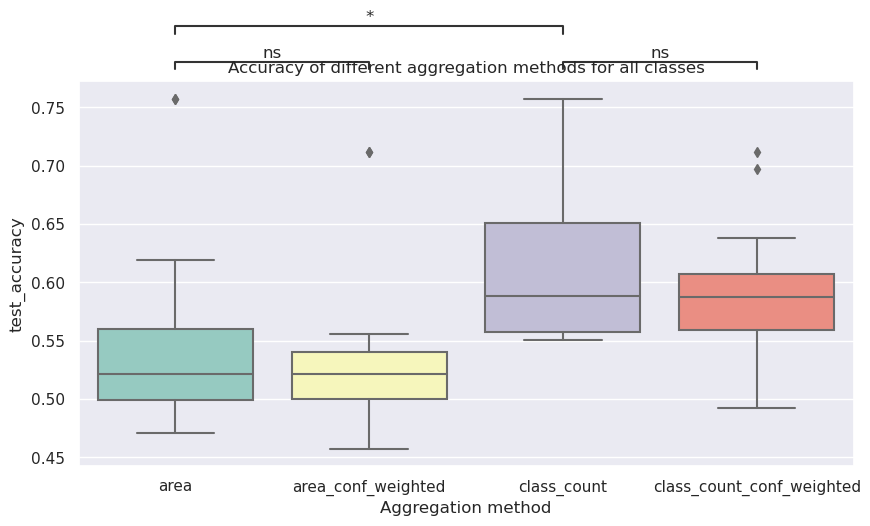

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt
from statannot import add_stat_annotation
from itertools import product

pairs = [('area', 'class_count'),
        ('area_conf_weighted', 'area'),
        ('class_count_conf_weighted', 'class_count')]

scores_all_classes = agg_scores.reset_index()

plt.figure(figsize=(10, 5))
ax = sns.boxplot(data=scores_all_classes, x="Aggregation method", y="test_accuracy", palette="Set3")
add_stat_annotation(ax, data=scores_all_classes, x="Aggregation method", y="test_accuracy",
                    box_pairs=pairs,
                    test='Mann-Whitney', text_format='star', loc='outside', verbose=2)
plt.title("Accuracy of different aggregation methods for all classes")
plt.show()

Comparing the different aggregation strategies show that incorporating the networks confidence does not significantly improve the network.
We can also see that the class count is not significantly more predicitve than the summed up area. This suggests to reject the hyptothesis that the area for this network has a significant informative value.

See if restricting to pathological classes makes a change

In [64]:
# Adding information whether class is pathological or not. For now I assume class 0, 2, 3 and 4 are pathological
# Class names: ['0: Airbronchograms', '1: Alines', '2: Blines', '3: Bpatch', '4: Consolidations', '5: Pleura', '6: Rib', '7: Shadow']
pathological_classes = [0, 2, 3, 4]
non_pathological_classes = [1, 5, 6, 7]
pathological_class_names = [class_names[x] for x in pathological_classes]
non_pathological_class_names = [class_names[x] for x in non_pathological_classes]
video_level["pathological_class"] = video_level["class"].apply(lambda x: 1 if x in pathological_classes else 0)

Train models on aggregated class (area) of all pathological classes:

In [65]:
# Train on all aggregation methods
agg_eval = pd.DataFrame()
agg_scores = pd.DataFrame()
agg_methods = ["area", "area_conf_weighted", "class_count", "class_count_conf_weighted"]
for agg_method in agg_methods:
    # Pivot table for regression
    class_area_per_video_pivot = video_level.pivot(index="video_name", columns="class_name", values=agg_method).reset_index()
    class_area_per_video_pivot = pd.merge(class_area_per_video_pivot, video_level[["video_name", "COVID19", "Bluepoint", "Patient ID"]], on="video_name")
    class_area_per_video_pivot = class_area_per_video_pivot.drop_duplicates().reset_index(drop=True)
    # Shuffle
    class_area_per_video_pivot = class_area_per_video_pivot.sample(frac=1, random_state=1).reset_index(drop=True)

    # Split into X and y
    X = class_area_per_video_pivot[pathological_class_names]
    y = class_area_per_video_pivot["COVID19"]
    groups = class_area_per_video_pivot["Patient ID"]

    # Train models
    scores, scores_mean = Classifier.train_models(X, y, groups=groups, plot=False)

    # Add index level to df for aggregation
    scores = pd.concat([scores], keys=[agg_method], names=['Aggregation method'])
    scores_mean = pd.concat([scores_mean], keys=[agg_method], names=['Aggregation method'])
    
    # Add to dataframe
    agg_scores = pd.concat([agg_scores, scores])
    agg_eval = pd.concat([agg_eval, scores_mean])

agg_eval.style.apply(highlight_max).format("{:.2f}")


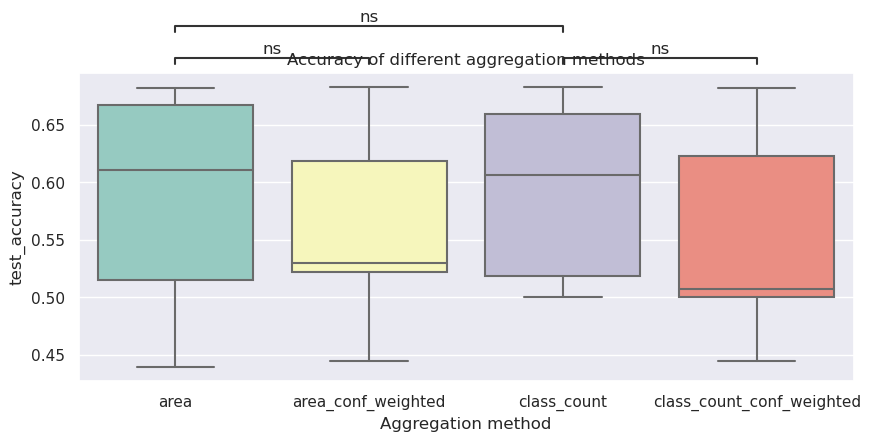

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt
from statannot import add_stat_annotation
from itertools import product

pairs = [('area', 'class_count'),
        ('area_conf_weighted', 'area'),
        ('class_count_conf_weighted', 'class_count'),
        ]

scores_pathological_classes = agg_scores.reset_index()

plt.figure(figsize=(10, 4))
ax = sns.boxplot(data=scores_pathological_classes, x="Aggregation method", y="test_accuracy", palette="Set3")
add_stat_annotation(ax, data=scores_pathological_classes, x="Aggregation method", y="test_accuracy",
                    box_pairs=pairs,
                    test='Mann-Whitney', text_format='star', loc='outside', verbose=0)
plt.title("Accuracy of different aggregation methods")
plt.show()

When restricting to the pathological classes there is no significant difference between either area or class_count and no significant difference when weighting by the networks confidence.

The mean of the class count is the highest which is why we will proceed using the class count as primary aggregation method.

In [67]:
# Mann-Whitney U-Test
x0 = scores_all_classes["test_accuracy"]
x1 = scores_pathological_classes["test_accuracy"]
stat, p_value = mannwhitneyu(x0, x1)
print(f"Mann–Whitney U Test: statistic={stat:.4f}, p-value={p_value:.4f}")
print(f"Mean accuracy all classes: {x0.mean():.4f}")
print(f"Mean accuracy pathological classes: {x1.mean():.4f}")

# Print green if p-value is significant otherwise red
if p_value < 0.05:
    print("\033[92mSignificant difference\033[0m")
else:
    print("\033[91mNo significant difference\033[0m")



Mann–Whitney U Test: statistic=1775.0000, p-value=0.8976
Mean accuracy all classes: 0.5751
Mean accuracy pathological classes: 0.5737
No significant difference


Testing on all trained models and all used aggregation strategies shows that restricting the model input to the pathological classes is not significantly better $(p > 0.05)$

This is to some extend not suprising since the information about the pathological classes is also contained in the full set of class names. Instead we check if restricting the model to only non-pathologocal classes decreases performance:

In [68]:
# Train on all aggregation methods
agg_eval = pd.DataFrame()
agg_scores = pd.DataFrame()
agg_methods = ["area", "area_conf_weighted", "class_count", "class_count_conf_weighted"]
for agg_method in agg_methods:
    # Pivot table for regression
    class_area_per_video_pivot = video_level.pivot(index="video_name", columns="class_name", values=agg_method).reset_index()
    class_area_per_video_pivot = pd.merge(class_area_per_video_pivot, video_level[["video_name", "COVID19", "Bluepoint", "Patient ID"]], on="video_name")
    class_area_per_video_pivot = class_area_per_video_pivot.drop_duplicates().reset_index(drop=True)
    # Shuffle
    class_area_per_video_pivot = class_area_per_video_pivot.sample(frac=1, random_state=1).reset_index(drop=True)

    # Split into X and y
    X = class_area_per_video_pivot[non_pathological_class_names]
    y = class_area_per_video_pivot["COVID19"]
    groups = class_area_per_video_pivot["Patient ID"]

    # Train models
    scores, scores_mean = Classifier.train_models(X, y, groups=groups, plot=False)

    # Add index level to df for aggregation
    scores = pd.concat([scores], keys=[agg_method], names=['Aggregation method'])
    scores_mean = pd.concat([scores_mean], keys=[agg_method], names=['Aggregation method'])
    
    # Add to dataframe
    agg_scores = pd.concat([agg_scores, scores])
    agg_eval = pd.concat([agg_eval, scores_mean])

agg_eval.style.apply(highlight_max).format("{:.2f}")


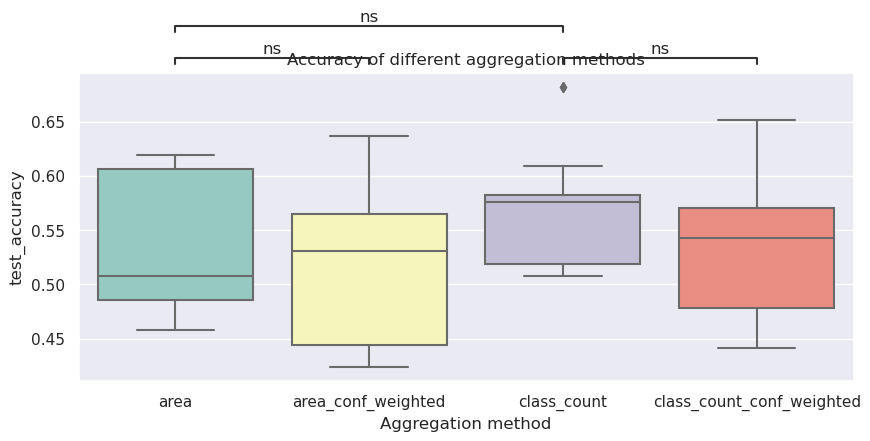

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt
from statannot import add_stat_annotation
from itertools import product

pairs = [('area', 'class_count'),
        ('area_conf_weighted', 'area'),
        ('class_count_conf_weighted', 'class_count'),
        ]

scores_non_pathological_classes = agg_scores.reset_index()

plt.figure(figsize=(10, 4))
ax = sns.boxplot(data=scores_non_pathological_classes, x="Aggregation method", y="test_accuracy", palette="Set3")
add_stat_annotation(ax, data=scores_non_pathological_classes, x="Aggregation method", y="test_accuracy",
                    box_pairs=pairs,
                    test='Mann-Whitney', text_format='star', loc='outside', verbose=0)
plt.title("Accuracy of different aggregation methods")
plt.show()

In [70]:
# Mann-Whitney U-Test
x0 = scores_all_classes["test_accuracy"]
x1 = scores_non_pathological_classes["test_accuracy"]
stat, p_value = mannwhitneyu(x0, x1)
print(f"Mann–Whitney U Test: statistic={stat:.4f}, p-value={p_value:.4f}")
print(f"Mean accuracy all classes: {x0.mean():.4f}")
print(f"Mean accuracy non pathological classes: {x1.mean():.4f}")

# Print green if p-value is significant otherwise red
if p_value < 0.05:
    print("\033[92mSignificant difference\033[0m")
else:
    print("\033[91mNo significant difference\033[0m")

Mann–Whitney U Test: statistic=2265.5000, p-value=0.0146
Mean accuracy all classes: 0.5751
Mean accuracy non pathological classes: 0.5358
Significant difference


Using all classes vs using only non-pathological classes for training makes a significant difference across all models.

### Patient level area analysis

In [71]:
# Add class count, weightes class count and weighted class area by confidence
yolo_detection_df["area_weighted"] = yolo_detection_df["area"] * yolo_detection_df["confidence"]
grp = yolo_detection_df.groupby(["Patient ID", "class"])
patient_lvl = grp.agg({"class": "count", "confidence": "sum", "area": "sum", "area_weighted": "sum"})
patient_lvl = patient_lvl.rename(columns={"class": "class_count", "confidence": "class_count_conf_weighted", "area": "area", "area_weighted": "area_conf_weighted"}).reset_index()

# Add frame count
frame_count_per_patient = yolo_detection_df[["Patient ID", "Bluepoint", "Frame"]].drop_duplicates().groupby(["Patient ID"]).count().reset_index().rename(columns={"Frame": "Frame_count"}).drop(columns=["Bluepoint"])
patient_lvl = pd.merge(patient_lvl, frame_count_per_patient, on="Patient ID")


# Devide by frame count to get the average area per frame
patient_lvl["area"] = patient_lvl["area"] / patient_lvl["Frame_count"]
patient_lvl["area_conf_weighted"] = patient_lvl["area_conf_weighted"] / patient_lvl["Frame_count"]
patient_lvl["class_count"] = patient_lvl["class_count"] / patient_lvl["Frame_count"]
patient_lvl["class_count_conf_weighted"] = patient_lvl["class_count_conf_weighted"] / patient_lvl["Frame_count"]


# Add classes with 0 area
possible_classes = list(range(len(class_names)))
patient_names = yolo_detection_df["Patient ID"].unique().tolist()
from itertools import product
idx_df =  pd.DataFrame(list(product(possible_classes, patient_names))).rename(columns={0:'class',1:'Patient ID'})

patient_lvl = pd.merge(idx_df, patient_lvl, on=["Patient ID", "class"], how="left").fillna(0).sort_values(by=["Patient ID", "class"])

patient_lvl["class_name"] = patient_lvl["class"].map(lambda x: class_names[x])

patient_data = yolo_detection_df.groupby(["Patient ID"]).agg({"COVID19": "first", "yolo_severity_score": "mean", "manual_severity_score": "mean"}).reset_index()
patient_lvl = pd.merge(patient_lvl, patient_data, on="Patient ID").sort_values(by=["Patient ID", "class"]).reset_index(drop=True)
# Reorder columns
patient_lvl = patient_lvl[["Patient ID", "COVID19", "yolo_severity_score", "manual_severity_score", "class", "class_name", "class_count", "class_count_conf_weighted", "area", "area_conf_weighted"]]

In [72]:
# Train on all aggregation methods
agg_eval = pd.DataFrame()
agg_scores = pd.DataFrame()
agg_methods = [#"area", 
            #"area_conf_weighted", 
            "class_count", 
            #"class_count_conf_weighted"
            ]
for agg_method in agg_methods:
    # Pivot table for regression
    class_area_per_patient_pivot = patient_lvl.pivot(index="Patient ID", columns="class_name", values=agg_method).reset_index()
    class_area_per_patient_pivot = pd.merge(class_area_per_patient_pivot, patient_lvl[["Patient ID" ,"COVID19"]], on="Patient ID")
    class_area_per_patient_pivot = class_area_per_patient_pivot.drop_duplicates().reset_index(drop=True)
    # Shuffle
    class_area_per_patient_pivot = class_area_per_patient_pivot.sample(frac=1, random_state=1).reset_index(drop=True)

    # Use all classes for the model
    X = class_area_per_patient_pivot[class_names]
    y = class_area_per_patient_pivot["COVID19"]

    # Train models
    scores, scores_mean = Classifier.train_models(X, y, plot=False)

    # Add index level to df for aggregation
    scores = pd.concat([scores], keys=[agg_method], names=['Aggregation method'])
    scores_mean = pd.concat([scores_mean], keys=[agg_method], names=['Aggregation method'])
    
    # Add to dataframe
    agg_scores = pd.concat([agg_scores, scores])
    agg_eval = pd.concat([agg_eval, scores_mean])

agg_eval.style.apply(highlight_max).format("{:.2f}")


In [73]:
print(agg_eval.style.apply(highlight_max).format("{:.2f}").to_latex())

\begin{tabular}{llrrrr}
 &  & test_accuracy & test_sensitivity & test_specificity & test_f1 \\
Aggregation method & model &  &  &  &  \\
\multirow[c]{3}{*}{class_count} & LR & \colorgreen 0.66 & 0.60 & \colorgreen 0.73 & \colorgreen 0.65 \\
 & RF & 0.61 & \colorgreen 0.63 & 0.59 & 0.63 \\
 & SVM & \colorgreen 0.66 & 0.60 & \colorgreen 0.73 & \colorgreen 0.65 \\
\end{tabular}



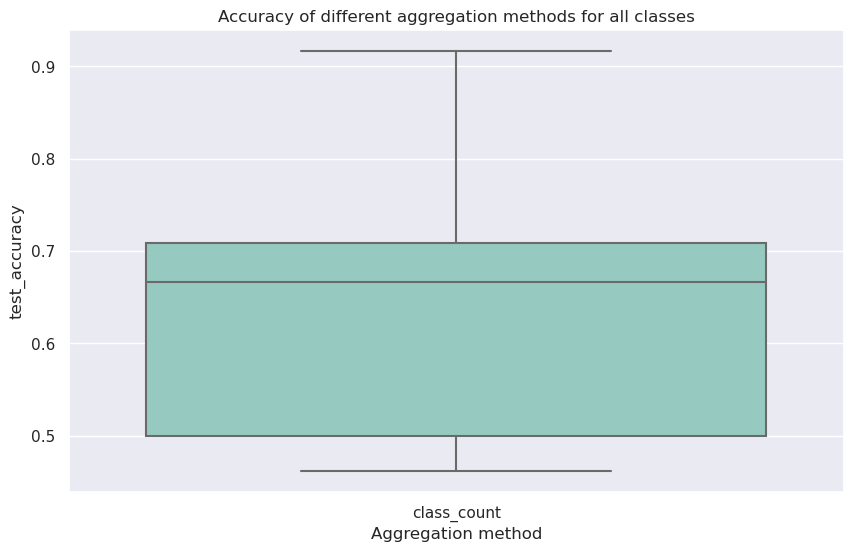

In [74]:
pairs = [('area', 'class_count'),
        # ('area_conf_weighted', 'area'),
        # ('class_count_conf_weighted', 'class_count'),
        ]

scores_all_classes = agg_scores.reset_index()

plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=scores_all_classes, x="Aggregation method", y="test_accuracy", palette="Set3")
# add_stat_annotation(ax, data=scores_all_classes, x="Aggregation method", y="test_accuracy",
                    # box_pairs=pairs,
                    # test='Mann-Whitney', text_format='star', loc='outside', verbose=2)
plt.title("Accuracy of different aggregation methods for all classes")
plt.show()

In [75]:
area_mean = scores_all_classes[scores_all_classes["Aggregation method"].isin(["area"])].mean().loc["test_accuracy"]
area_std = scores_all_classes[scores_all_classes["Aggregation method"].isin(["area"])].std().loc["test_accuracy"]
class_count_mean = scores_all_classes[scores_all_classes["Aggregation method"].isin(["class_count"])].mean().loc["test_accuracy"]
class_count_std = scores_all_classes[scores_all_classes["Aggregation method"].isin(["class_count"])].std().loc["test_accuracy"]

print(f"Area mean: {area_mean:.2f} +- {area_std:.2f}")
print(f"Class count mean: {class_count_mean:.2f} +- {class_count_std:.2f}")


Area mean: nan +- nan
Class count mean: 0.64 +- 0.15


Again the patient level improves the results significantly. Similarly to before try using only pathological classes for prediction:

In [76]:
# Train on all aggregation methods
agg_eval = pd.DataFrame()
agg_scores = pd.DataFrame()
agg_methods = ["area", 
            "area_conf_weighted", 
            "class_count", 
            "class_count_conf_weighted"
            ]
for agg_method in agg_methods:
    # Pivot table for regression
    class_area_per_patient_pivot = patient_lvl.pivot(index="Patient ID", columns="class_name", values=agg_method).reset_index()
    class_area_per_patient_pivot = pd.merge(class_area_per_patient_pivot, patient_lvl[["Patient ID" ,"COVID19"]], on="Patient ID")
    class_area_per_patient_pivot = class_area_per_patient_pivot.drop_duplicates().reset_index(drop=True)
    # Shuffle
    class_area_per_patient_pivot = class_area_per_patient_pivot.sample(frac=1, random_state=1).reset_index(drop=True)

    # Use all classes for the model
    X = class_area_per_patient_pivot[pathological_class_names]
    y = class_area_per_patient_pivot["COVID19"]

    # Train models
    scores, scores_mean = Classifier.train_models(X, y, plot=False)

    # Add index level to df for aggregation
    scores = pd.concat([scores], keys=[agg_method], names=['Aggregation method'])
    scores_mean = pd.concat([scores_mean], keys=[agg_method], names=['Aggregation method'])
    
    # Add to dataframe
    agg_scores = pd.concat([agg_scores, scores])
    agg_eval = pd.concat([agg_eval, scores_mean])

agg_eval.style.apply(highlight_max).format("{:.2f}")


Eyeballing the results the filtering for only the pathological classes makes for a slight improvement on the patient level.

In [77]:
scores_pathological_classes = agg_scores.reset_index()
# Mann-Whitney U-Test
x0 = scores_all_classes["test_accuracy"]
x1 = scores_pathological_classes["test_accuracy"]
stat, p_value = mannwhitneyu(x0, x1)
print(f"Mann–Whitney U Test: statistic={stat:.4f}, p-value={p_value:.4f}")
print(f"Mean accuracy all classes: {x0.mean():.4f}")
print(f"Mean accuracy pathological classes: {x1.mean():.4f}")

# Print green if p-value is significant otherwise red
if p_value < 0.05:
    print("\033[92mSignificant difference\033[0m")
else:
    print("\033[91mNo significant difference\033[0m")


Mann–Whitney U Test: statistic=503.5000, p-value=0.4733
Mean accuracy all classes: 0.6419
Mean accuracy pathological classes: 0.5988
No significant difference


In [78]:
# Train on all aggregation methods
agg_eval = pd.DataFrame()
agg_scores = pd.DataFrame()
agg_methods = ["area", 
            "area_conf_weighted", 
            "class_count", 
            "class_count_conf_weighted"
            ]
for agg_method in agg_methods:
    # Pivot table for regression
    class_area_per_patient_pivot = patient_lvl.pivot(index="Patient ID", columns="class_name", values=agg_method).reset_index()
    class_area_per_patient_pivot = pd.merge(class_area_per_patient_pivot, patient_lvl[["Patient ID" ,"COVID19"]], on="Patient ID")
    class_area_per_patient_pivot = class_area_per_patient_pivot.drop_duplicates().reset_index(drop=True)
    # Shuffle
    class_area_per_patient_pivot = class_area_per_patient_pivot.sample(frac=1, random_state=1).reset_index(drop=True)

    # Use all classes for the model
    X = class_area_per_patient_pivot[non_pathological_class_names]
    y = class_area_per_patient_pivot["COVID19"]

    # Train models
    scores, scores_mean = Classifier.train_models(X, y, plot=False)

    # Add index level to df for aggregation
    scores = pd.concat([scores], keys=[agg_method], names=['Aggregation method'])
    scores_mean = pd.concat([scores_mean], keys=[agg_method], names=['Aggregation method'])
    
    # Add to dataframe
    agg_scores = pd.concat([agg_scores, scores])
    agg_eval = pd.concat([agg_eval, scores_mean])

agg_eval.style.apply(highlight_max).format("{:.2f}")


In [79]:
scores_non_pathological_classes = agg_scores.reset_index()
# Mann-Whitney U-Test
x0 = scores_all_classes["test_accuracy"]
x1 = scores_non_pathological_classes["test_accuracy"]
stat, p_value = mannwhitneyu(x0, x1)
print(f"Mann–Whitney U Test: statistic={stat:.4f}, p-value={p_value:.4f}")
print(f"Mean accuracy all classes: {x0.mean():.4f}")
print(f"Mean accuracy non-pathological classes: {x1.mean():.4f}")

# Print green if p-value is significant otherwise red
if p_value < 0.05:
    print("\033[92mSignificant difference\033[0m")
else:
    print("\033[91mNo significant difference\033[0m")

Mann–Whitney U Test: statistic=605.5000, p-value=0.0380
Mean accuracy all classes: 0.6419
Mean accuracy non-pathological classes: 0.5421
Significant difference


## Bluepoint information added to class area on video level

In [80]:
# Train on all aggregation methods
agg_eval = pd.DataFrame()
agg_scores = pd.DataFrame()
agg_methods = ["area", 
            "area_conf_weighted", 
            "class_count", 
            "class_count_conf_weighted"
            ]
for agg_method in agg_methods:
    # Pivot table for regression
    class_area_per_patient_pivot = patient_lvl.pivot(index="Patient ID", columns="class_name", values=agg_method).reset_index()
    class_area_per_patient_pivot = pd.merge(class_area_per_patient_pivot, patient_lvl[["Patient ID" ,"COVID19"]], on="Patient ID")
    class_area_per_patient_pivot = class_area_per_patient_pivot.drop_duplicates().reset_index(drop=True)
    # Shuffle
    class_area_per_patient_pivot = class_area_per_patient_pivot.sample(frac=1, random_state=1).reset_index(drop=True)

    # Filter out video with Bluepoint == None
    class_area_per_video_pivot = class_area_per_video_pivot[class_area_per_video_pivot["Bluepoint"] != 'None']
    # Get list of Bluepoint values
    bluepoints = class_area_per_video_pivot.Bluepoint.unique().tolist()
    bluepoints.sort()
    # Create a dictionary for mapping Bluepoint values to integers
    bp2code = {bp: i for i, bp in enumerate(bluepoints)}
    code2bp = {i: bp for i, bp in enumerate(bluepoints)}
    # Map Bluepoint values to integers 
    class_area_per_video_pivot["Bluepoint_codes"] = class_area_per_video_pivot["Bluepoint"].apply(lambda x: bp2code[x])

    X = class_area_per_video_pivot[class_names + ["Bluepoint_codes"]]
    y = class_area_per_video_pivot["COVID19"]

    # Train models
    scores, scores_mean = Classifier.train_models(X, y, plot=False)

    # Add index level to df for aggregation
    scores = pd.concat([scores], keys=[agg_method], names=['Aggregation method'])
    scores_mean = pd.concat([scores_mean], keys=[agg_method], names=['Aggregation method'])
    
    # Add to dataframe
    agg_scores = pd.concat([agg_scores, scores])
    agg_eval = pd.concat([agg_eval, scores_mean])

agg_eval.style.apply(highlight_max).format("{:.2f}")


In [81]:
scores_all_classes_plus_pb = agg_scores.reset_index()
# Mann-Whitney U-Test
x0 = scores_all_classes["test_accuracy"]
x1 = scores_all_classes_plus_pb["test_accuracy"]
stat, p_value = mannwhitneyu(x0, x1)
print(f"Mann–Whitney U Test: statistic={stat:.4f}, p-value={p_value:.4f}")
print(f"Mean accuracy all classes: {x0.mean():.4f}")
print(f"Mean accuracy classes + bp: {x1.mean():.4f}")

# Print green if p-value is significant otherwise red
if p_value < 0.05:
    print("\033[92mSignificant difference\033[0m")
else:
    print("\033[91mNo significant difference\033[0m")

Mann–Whitney U Test: statistic=556.0000, p-value=0.1595
Mean accuracy all classes: 0.6419
Mean accuracy classes + bp: 0.5640
No significant difference


Adding information about where the video was taken interestingly does not improve the performance compared to the model simply using all pathological classes.

### Training one model per Bluepoint

In [82]:
bluepoint_models = pd.DataFrame()
bluepoint_models_all = pd.DataFrame()
for bp in bluepoints:
    print(f"Training model for {bp}...")
    bp_df = class_area_per_video_pivot[class_area_per_video_pivot["Bluepoint"] == bp]
    X = bp_df[class_names]
    y = bp_df["COVID19"]

    scores, scores_mean = Classifier.train_models(X, y, plot=False)
    scores = pd.concat([scores], keys=[bp], names=['Bluepoint'])
    scores_mean = pd.concat([scores_mean], keys=[bp], names=['Bluepoint'])

    bluepoint_models_all = pd.concat([bluepoint_models_all, scores])
    bluepoint_models = pd.concat([bluepoint_models, scores_mean])


bluepoint_models.style.apply(highlight_max).format("{:.2f}")


Training model for L1...
Training model for L2...
Training model for L3...
Training model for R1...
Training model for R2...
Training model for R3...


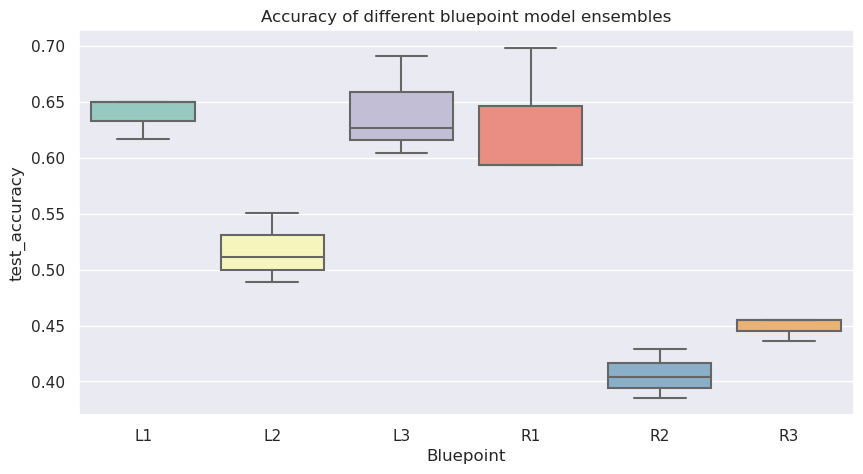

In [83]:
bluepoint_models = bluepoint_models.reset_index()

plt.figure(figsize=(10, 5))
ax = sns.boxplot(data=bluepoint_models, x="Bluepoint", y="test_accuracy", palette="Set3")
plt.title("Accuracy of different bluepoint model ensembles")
plt.show()

/tmp/ipykernel_1263/1050788252.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])


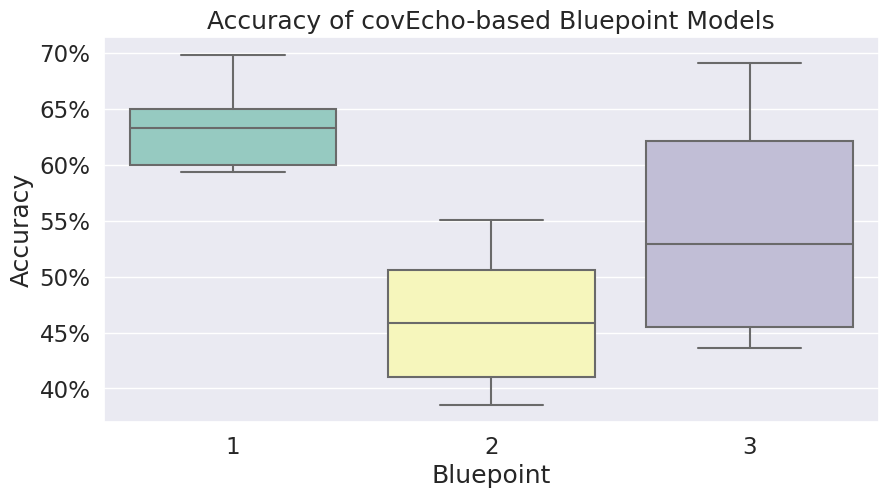

In [84]:
# Assigning L1 and R1 to the bilateral bluepoint "1", L2 and R2 to "2" and L3 and R3 to "3" for aggregated plotting
bluepoint_models["Bluepoint_bilateral"] = bluepoint_models["Bluepoint"].apply(lambda x: x[1])

plt.figure(figsize=(10, 5))
sns.set(font_scale=1.5)
ax = sns.boxplot(data=bluepoint_models, x="Bluepoint_bilateral", y="test_accuracy", palette="Set3")
ax.set_xlabel("Bluepoint")
ax.set_ylabel("Accuracy")
# Display y ticks as percentage
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
plt.title("Accuracy of covEcho-based Bluepoint Models")
plt.show()

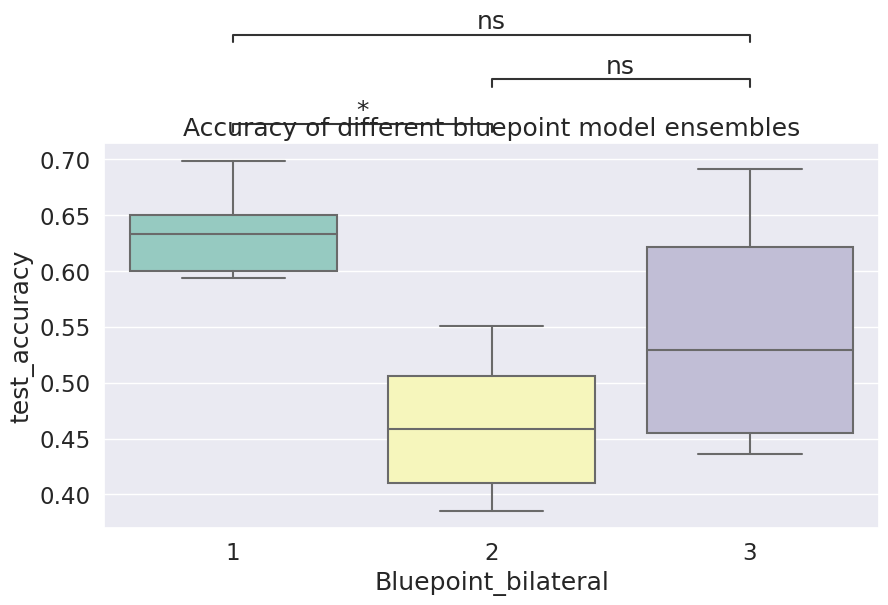

In [85]:
from statannot import add_stat_annotation

# Assigning L1 and R1 to the bilateral bluepoint "1", L2 and R2 to "2" and L3 and R3 to "3" for aggregated plotting
bluepoint_models["Bluepoint_bilateral"] = bluepoint_models["Bluepoint"].apply(lambda x: x[1])

pairs = [('1', '2'),
        ('1', '3'),
        ('2', '3'),
        ]

plt.figure(figsize=(10, 5))
ax = sns.boxplot(data=bluepoint_models, x="Bluepoint_bilateral", y="test_accuracy", palette="Set3")
add_stat_annotation(ax, data=bluepoint_models, x="Bluepoint_bilateral", y="test_accuracy",
                    box_pairs=pairs,
                    test='Mann-Whitney', text_format='star', loc='outside', verbose=0)
plt.title("Accuracy of different bluepoint model ensembles")
plt.show()

In [86]:
bp_left = bluepoint_models_all.loc[["L1", "L2", "L3"]].test_accuracy
bp_right = bluepoint_models_all.loc[["R1", "R2", "R3"]].test_accuracy

bp_1 = bluepoint_models_all.loc[["L1", "R1"]].test_accuracy
bp_2 = bluepoint_models_all.loc[["L2", "R2"]].test_accuracy
bp_3 = bluepoint_models_all.loc[["L3", "R3"]].test_accuracy

p_values = []

# Mann-Whitney U-Test
# stat, p_value = mannwhitneyu(bp_left, bp_right)
# p_values.append(p_value)
# print("Bluepoint left vs right")
# print(f"Mann–Whitney U Test: statistic={stat:.4f}, p-value={p_value:.4f}")
# print(f"Mean accuracy left: {bp_left.mean():.4f}")
# print(f"Mean accuracy right: {bp_right.mean():.4f}")

print("Bluepoint 1 vs 2 vs 3")
print("1 vs 2")
stat, p_value = mannwhitneyu(bp_1, bp_2)
p_values.append(p_value)
print(f"Mann–Whitney U Test: statistic={stat:.4f}, p-value={p_value:.4f}")
print("2 vs 3")
stat, p_value = mannwhitneyu(bp_2, bp_3)
p_values.append(p_value)
print(f"Mann–Whitney U Test: statistic={stat:.4f}, p-value={p_value:.4f}")
print("1 vs 3")
stat, p_value = mannwhitneyu(bp_1, bp_3)
p_values.append(p_value)
print(f"Mann–Whitney U Test: statistic={stat:.4f}, p-value={p_value:.4f}")

print("\n Means:")
print(f"Mean accuracy 1: {bp_1.mean():.4f}")
print(f"Mean accuracy 2: {bp_2.mean():.4f}")
print(f"Mean accuracy 3: {bp_3.mean():.4f}")

Bluepoint 1 vs 2 vs 3
1 vs 2
Mann–Whitney U Test: statistic=713.5000, p-value=0.0001
2 vs 3
Mann–Whitney U Test: statistic=318.0000, p-value=0.0510
1 vs 3
Mann–Whitney U Test: statistic=551.0000, p-value=0.1363

 Means:
Mean accuracy 1: 0.6338
Mean accuracy 2: 0.4615
Mean accuracy 3: 0.5446


In [87]:
# Using bonferonni correction for multiple comparisons
from statsmodels.sandbox.stats.multicomp import multipletests
p_adjusted = multipletests(p_values, method='bonferroni')

print("Bonferroni corrected p-values:")

test_distributions = [#"L vs R", 
                    "1 vs 2", 
                    "2 vs 3", 
                    "1 vs 3"]
# Print green if p-value is significant otherwise red
for i, p in enumerate(p_adjusted[1]):
    if p < 0.05:
        print(f"\033[92m{test_distributions[i]}: {p:.4f}\033[0m")
    else:
        print(f"\033[91m{test_distributions[i]}: {p:.4f}\033[0m")



Bonferroni corrected p-values:
1 vs 2: 0.0003
2 vs 3: 0.1529
1 vs 3: 0.4090


The models trained on L1 and R1 perform significantly better.

### Train only on BP 1 & 3

In [88]:
# Filter out video with Bluepoint not L1 or R1
yolo_detection_df_filtered = yolo_detection_df[yolo_detection_df["Bluepoint"].isin(["L1", "R1", "L3", "R3"])]

grp = yolo_detection_df_filtered.groupby(["Patient ID", "class"])
patient_lvl = grp.agg({"class": "count", "confidence": "sum", "area": "sum", "area_weighted": "sum"})
patient_lvl = patient_lvl.rename(columns={"class": "class_count", "confidence": "class_count_conf_weighted", "area": "area", "area_weighted": "area_conf_weighted"}).reset_index()

# Add frame count
frame_count_per_patient = yolo_detection_df_filtered[["Patient ID", "Bluepoint", "Frame"]].drop_duplicates().groupby(["Patient ID"]).count().reset_index().rename(columns={"Frame": "Frame_count"}).drop(columns=["Bluepoint"])
patient_lvl = pd.merge(patient_lvl, frame_count_per_patient, on="Patient ID")


# Devide by frame count to get the average area per frame
patient_lvl["area"] = patient_lvl["area"] / patient_lvl["Frame_count"]
patient_lvl["area_conf_weighted"] = patient_lvl["area_conf_weighted"] / patient_lvl["Frame_count"]
patient_lvl["class_count"] = patient_lvl["class_count"] / patient_lvl["Frame_count"]
patient_lvl["class_count_conf_weighted"] = patient_lvl["class_count_conf_weighted"] / patient_lvl["Frame_count"]


# Add classes with 0 area
possible_classes = list(range(len(class_names)))
patient_names = yolo_detection_df_filtered["Patient ID"].unique().tolist()
from itertools import product
idx_df =  pd.DataFrame(list(product(possible_classes, patient_names))).rename(columns={0:'class',1:'Patient ID'})

patient_lvl = pd.merge(idx_df, patient_lvl, on=["Patient ID", "class"], how="left").fillna(0).sort_values(by=["Patient ID", "class"])

patient_lvl["class_name"] = patient_lvl["class"].map(lambda x: class_names[x])

patient_data = yolo_detection_df_filtered.groupby(["Patient ID"]).agg({"COVID19": "first", "yolo_severity_score": "mean", "manual_severity_score": "mean"}).reset_index()
patient_lvl = pd.merge(patient_lvl, patient_data, on="Patient ID").sort_values(by=["Patient ID", "class"]).reset_index(drop=True)
# Reorder columns
patient_lvl = patient_lvl[["Patient ID", "COVID19", "yolo_severity_score", "manual_severity_score", "class", "class_name", "class_count", "class_count_conf_weighted", "area", "area_conf_weighted"]]

In [89]:
# Train on all aggregation methods
agg_eval = pd.DataFrame()
agg_scores = pd.DataFrame()
agg_methods = ["area", 
            #"area_conf_weighted", 
            "class_count", 
            #"class_count_conf_weighted"
            ]
for agg_method in agg_methods:
    # Pivot table for regression
    class_area_per_patient_pivot = patient_lvl.pivot(index="Patient ID", columns="class_name", values=agg_method).reset_index()
    class_area_per_patient_pivot = pd.merge(class_area_per_patient_pivot, patient_lvl[["Patient ID" ,"COVID19"]], on="Patient ID")
    class_area_per_patient_pivot = class_area_per_patient_pivot.drop_duplicates().reset_index(drop=True)
    # Shuffle
    class_area_per_patient_pivot = class_area_per_patient_pivot.sample(frac=1, random_state=1).reset_index(drop=True)

    # Use all classes for the model
    X = class_area_per_patient_pivot[class_names]
    y = class_area_per_patient_pivot["COVID19"]
    # groups = class_area_per_patient_pivot["Patient ID"]

    # Train models
    scores, scores_mean = Classifier.train_models(X, y, 
                                                # groups=groups, 
                                                plot=False)
    
    # Add index level to df for aggregation
    scores = pd.concat([scores], keys=[agg_method], names=['Aggregation method'])
    scores_mean = pd.concat([scores_mean], keys=[agg_method], names=['Aggregation method'])
    
    # Add to dataframe
    agg_scores = pd.concat([agg_scores, scores])
    agg_eval = pd.concat([agg_eval, scores_mean])

agg_eval.style.apply(highlight_max).format("{:.2f}")


In [90]:
print(agg_eval.style.apply(highlight_max).format("{:.2f}").to_latex())

\begin{tabular}{llrrrr}
 &  & test_accuracy & test_sensitivity & test_specificity & test_f1 \\
Aggregation method & model &  &  &  &  \\
\multirow[c]{3}{*}{area} & LR & \colorgreen 0.72 & 0.66 & \colorgreen 0.80 & \colorgreen 0.70 \\
 & RF & 0.65 & \colorgreen 0.75 & 0.57 & 0.69 \\
 & SVM & 0.69 & 0.63 & 0.77 & 0.67 \\
\multirow[c]{3}{*}{class_count} & LR & 0.66 & 0.66 & 0.67 & 0.67 \\
 & RF & 0.62 & 0.60 & 0.67 & 0.61 \\
 & SVM & 0.63 & 0.60 & 0.67 & 0.63 \\
\end{tabular}



Interestingly, only training on L1 and R1 does not seem to improve the overall model performance however.

## Multi class classification for manual severity score

In [91]:
import importlib
import ml_pipeline
importlib.reload(ml_pipeline)
from ml_pipeline import ModelEvaluation


Multi_Classifier = ModelEvaluation(mode="classification_multi_label")

/scratch_net/gnarf/mrichte/conda_envs/DL4LUS/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/scratch_net/gnarf/mrichte/conda_envs/DL4LUS/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/scratch_net/gnarf/mrichte/conda_envs/DL4LUS/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/scr

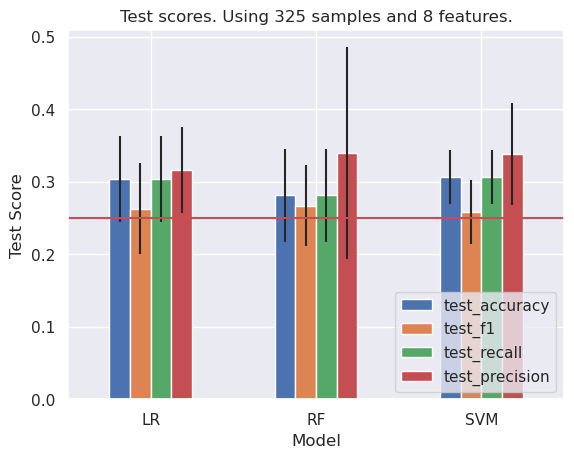

,test_accuracy,test_f1,test_recall,test_precision
model,,,,
LR,0.30,0.26,0.30,0.32
RF,0.28,0.27,0.28,0.34
SVM,0.31,0.26,0.31,0.34


In [101]:
# Pivot table for regression
class_area_per_video_pivot = video_level.pivot(index="video_name", columns="class_name", values="class_count").reset_index()
class_area_per_video_pivot = pd.merge(class_area_per_video_pivot, video_level[["video_name", "COVID19", "Bluepoint", "Patient ID", "manual_severity_score"]], on="video_name")
class_area_per_video_pivot = class_area_per_video_pivot.drop_duplicates().reset_index(drop=True)
# Shuffle
class_area_per_video_pivot = class_area_per_video_pivot.sample(frac=1, random_state=1).reset_index(drop=True)
class_area_per_video_pivot = class_area_per_video_pivot.dropna(subset=["manual_severity_score"])
video_lvl = class_area_per_video_pivot
# Split into X and y
X = video_lvl[class_names]
y = video_lvl["manual_severity_score"]
groups = video_lvl["Patient ID"]

# Train models
scores, scores_mean, predictions = Multi_Classifier.train_models(X, y, groups=groups, return_model_predictions=video_lvl)

scores_mean.style.apply(highlight_max).format("{:.2f}")

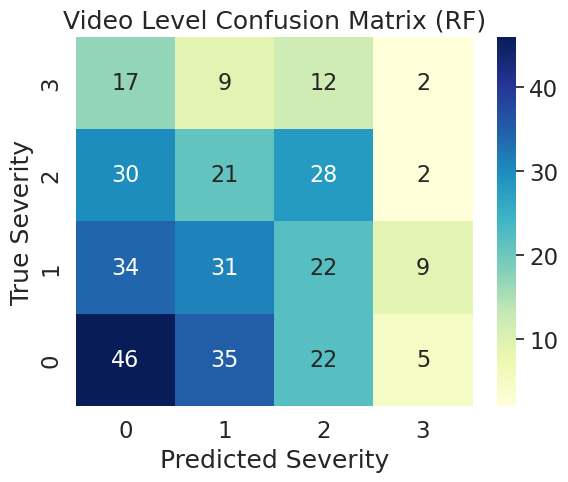

In [104]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions
y_pred = predictions["RF"].values
y_true = y.values

# Get confusion matrix
cm = confusion_matrix(y_true, y_pred)
#cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

df_cm = pd.DataFrame(cm, range(4), range(4))
# Flipping y axis
df_cm_video = df_cm.iloc[::-1]
# plt.figure(figsize=(10,7))
sns.set(font_scale=1.5) # for label size
sns.heatmap(df_cm_video, annot=True, annot_kws={"size": 16}, cmap="YlGnBu", fmt="d").set(xlabel="Predicted Severity", ylabel="True Severity", title="Video Level Confusion Matrix (RF)")

plt.show()


In [94]:
# scores_mean to latex format .2f
print(scores_mean.style.format("{:.2f}").to_latex())

\begin{tabular}{lrrrr}
 & test_accuracy & test_f1 & test_recall & test_precision \\
model &  &  &  &  \\
LR & 0.30 & 0.26 & 0.30 & 0.32 \\
RF & 0.33 & 0.32 & 0.33 & 0.40 \\
SVM & 0.31 & 0.26 & 0.31 & 0.34 \\
\end{tabular}



/scratch_net/gnarf/mrichte/conda_envs/DL4LUS/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/scratch_net/gnarf/mrichte/conda_envs/DL4LUS/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/scratch_net/gnarf/mrichte/conda_envs/DL4LUS/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/scratch_net/gnarf/mrichte/conda_envs/DL4LUS/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

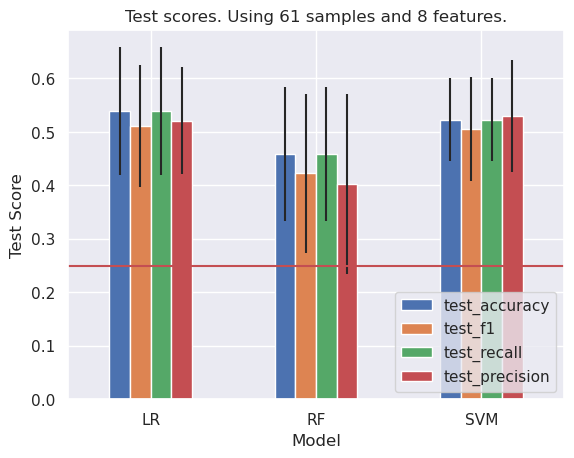

,test_accuracy,test_f1,test_recall,test_precision
model,,,,
LR,0.54,0.51,0.54,0.52
RF,0.46,0.42,0.46,0.40
SVM,0.52,0.51,0.52,0.53


In [95]:
# Pivot table for regression
class_area_per_patient_pivot = patient_lvl.pivot(index="Patient ID", columns="class_name", values="class_count").reset_index()
class_area_per_patient_pivot = pd.merge(class_area_per_patient_pivot, patient_lvl[["Patient ID" ,"COVID19", "manual_severity_score"]], on="Patient ID")
class_area_per_patient_pivot = class_area_per_patient_pivot.drop_duplicates().reset_index(drop=True)
# Shuffle
class_area_per_patient_pivot = class_area_per_patient_pivot.sample(frac=1, random_state=1).reset_index(drop=True)
# Cast manual severity score to int
class_area_per_patient_pivot["manual_severity_score"] = class_area_per_patient_pivot["manual_severity_score"].astype(int)
# Split into X and y
X = class_area_per_patient_pivot[class_names]
y = class_area_per_patient_pivot["manual_severity_score"]

# Train models
scores_patient, scores_mean_patient = Multi_Classifier.train_models(X, y)

scores_mean_patient.style.apply(highlight_max).format("{:.2f}")

In [96]:
# scores_mean to latex format .2f
print(scores_mean_patient.style.format("{:.2f}").to_latex())

\begin{tabular}{lrrrr}
 & test_accuracy & test_f1 & test_recall & test_precision \\
model &  &  &  &  \\
LR & 0.54 & 0.51 & 0.54 & 0.52 \\
RF & 0.46 & 0.42 & 0.46 & 0.40 \\
SVM & 0.52 & 0.51 & 0.52 & 0.53 \\
\end{tabular}



,test_accuracy,test_f1,test_recall,test_precision
Patient (LR),0.54,0.51,0.54,0.52
Video (RF),0.33,0.32,0.33,0.40


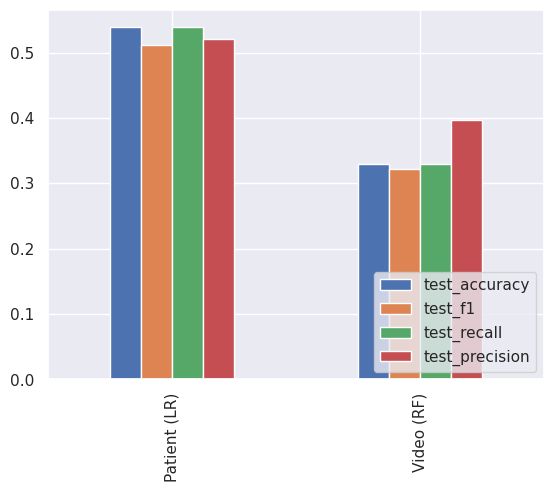

In [97]:
# summarize scores_mean and scores_mean_patient in one dataframe
# Add index level to df for aggregation
scores_mean = pd.concat([scores_mean], keys=["Video"], names=['Level'])
scores_mean_patient = pd.concat([scores_mean_patient], keys=["Patient"], names=['Level'])
# Concatenate
scores_mean = pd.concat([scores_mean, scores_mean_patient])

grouped = scores_mean.groupby("Level")
max_index = grouped["test_accuracy"].idxmax()
best_models = scores_mean.loc[max_index].sort_values("test_accuracy", ascending=False)
best_models.index = best_models.reset_index().Level + " (" + best_models.reset_index().model + ")"

best_models.plot.bar()
plt.legend(loc='lower right')

best_models.style.apply(highlight_max).format("{:.2f}")


In [98]:
print(best_models.style.format("{:.2f}").to_latex())

\begin{tabular}{lrrrr}
 & test_accuracy & test_f1 & test_recall & test_precision \\
Patient (LR) & 0.54 & 0.51 & 0.54 & 0.52 \\
Video (RF) & 0.33 & 0.32 & 0.33 & 0.40 \\
\end{tabular}



In [99]:
# Get std of scores
scores_std = scores.groupby(["model"]).std()
scores_std

,fit_time,score_time,test_accuracy,test_f1,test_recall,test_precision
model,,,,,,
LR,0.000711,0.000353,0.059837,0.062815,0.059837,0.059107
RF,0.003130,0.000054,0.047169,0.043593,0.047169,0.085096
SVM,0.020813,0.001086,0.037358,0.044425,0.037358,0.070496
